In [68]:
import numpy as np
from astropy import units as u
from astropy import coordinates as astrocoords
import os
import pandas as pd
from scipy.optimize import minimize
from pathlib import Path
from astropy.io import fits
import matplotlib.pyplot as plt

class Parallax:
    """Handle observatory parallax calculations.

    The class rotates observatory ephemerides into the reference frame aligned
    with a microlensing event and converts positional offsets from the time--
    impact parameter (``tau``, ``u``) system into north/east coordinates.  It
    also provides utilities for converting those coordinates back into the
    observatory frame.
    """

    def __init__(
        self,
        ra,
        dec,
        orbit,
        t_ref,
        tu=None,
        piE=None,
        epochs=None,
    ):
        """Create a parallax helper.

        Parameters
        ----------
        ra, dec : float
            Right ascension and declination of the event in degrees.
        orbit : :class:`Orbit`
            Observatory ephemeris describing the position and velocity as a
            function of time.
        t_ref : float
            Reference time in Julian days used to define the zero point of the
            parallax shift.
        tu : array_like, optional
            Precomputed parallax shift in the ``(\tau, u)`` frame.  If given it
            should be indexed by observatory name.
        piE : array_like, optional
            Microlensing parallax vector ``(\pi_{EN}, \pi_{EE})`` associated with
            ``tu``.
        epochs : dict, optional
            Dictionary mapping observatory names to the epochs of ``tu``.

        Attributes
        ----------
        ra, dec : :class:`astropy.units.Quantity`
            Coordinates of the microlensing event.
        orbit : Orbit
            Observatory ephemerides.
        tref : float
            Reference time used to centre the parallax shift.
        xref, vref : `numpy.ndarray`
            Observatory position and velocity at ``t_ref``.
        tu, ne : dict or None
            Pre-computed shifts in ``(\tau, u)`` and north/east coordinates
            indexed by observatory name when provided.

        Notes
        -----
        When ``tu`` is supplied the shift is immediately converted to north and
        east components via :meth:`tu2ne` and stored on the instance.
        """
        self.ra = ra * u.deg
        self.dec = dec * u.deg
        self.event_coords = astrocoords.SkyCoord(
            ra=self.ra, dec=self.dec, frame="icrs"
        )
        self.orbit = orbit
        self.set_ref_frame(t_ref)
        self.rotate_view()

        if tu is not None:
            self.tu = tu
            self.epochs = epochs
            ne = {}
            for obs in tu.keys():
                ne[obs] = self.tu2ne(tu[obs], piE)
                # print('observatory key:', obs)
                # print('ne', ne[obs], ne[obs].shape)
                # print('tu', tu[obs], tu[obs].shape)
            self.ne = ne
        else:
            self.tu = None
            self.ne = None

        # Event->pllx[obsidx].reset();

    # Event->pllx[obsidx].set_reference(
    #     Paramfile->simulation_zerotime + tref,
    #     &World[0].orbit,
    # )
    # Event->pllx[obsidx].set_orbit(&World[obsidx].orbit)
    # Event->pllx[obsidx].set_lb(Event->l, Event->b)
    # Event->pllx[obsidx].set_pm_lb(
    #     Lenses->data[ln][MUL] - Sources->data[sn][MUL],
    #     Lenses->data[ln][MUB] - Sources->data[sn][MUB],
    # )
    # Event->pllx[obsidx].set_piE(Event->piE)
    # Event->pllx[obsidx].set_tE_h(Event->tE_h)  # tE in the heliocentric frame

    def set_ref_frame(self, t_ref):
        """Define the reference frame for the parallax calculation.

        Parameters
        ----------
        t_ref : float
            Reference time in Julian days used to centre the parallax shift.
        """

        self.tref = t_ref  # bjd
        self.xref = self.orbit.get_pos(t_ref)
        self.vref = self.orbit.get_vel(t_ref)

    def update_piE_NE(self, piEN, piEE):
        """Set the microlensing parallax components.

        Parameters
        ----------
        piEN, piEE : float
            North and east components of the microlensing parallax vector.
        """

        self.piEN = piEN
        self.piEE = piEE

        self.piE = np.array([piEN, piEE])

    def dperp(self, t1, t2=None):
        """Return the distance perpendicular to the line of sight.

        The separation is computed between two heliocentric positions.  When a
        second epoch is not supplied the reference time ``tref`` is used.

        Parameters
        ----------
        t1 : float or array_like
            Times (JD) of the first position.
        t2 : float or array_like, optional
            Times (JD) of the second position.  If ``None`` ``self.tref`` is
            used.

        Returns
        -------
        numpy.ndarray
            Perpendicular separation in astronomical units.  A scalar is
            returned when ``t1`` and ``t2`` are single values.
        """

        pos1 = self.orbit.get_pos(t1)
        if t2 is None:
            pos2 = self.orbit.get_pos(self.tref)
        else:
            pos2 = self.orbit.get_pos(t2)

        delta = pos1 - pos2
        cross = np.cross(self.rad, delta.T).T
        return np.linalg.norm(cross, axis=0)

    def rotate_view(self):
        """Rotate observatory vectors into the event frame.

        The transformation aligns the ``z`` axis with the line of sight to the
        event such that the resulting coordinates correspond to north, east and
        the line-of-sight (``n``, ``e``, ``d``).
        """

        # unit vector pointing to the source
        self.rad = np.array(
            [
                np.cos(self.ra.to(u.rad).value)
                * np.cos(self.dec.to(u.rad).value),
                np.sin(self.ra.to(u.rad).value)
                * np.cos(self.dec.to(u.rad).value),
                np.sin(self.dec.to(u.rad).value),
            ]
        )

        # north vector in x, y, z
        north = np.array([0, 0, 1])

        # unit vector pointing east in the lens plane
        e_unit = np.cross(north, self.rad) / np.linalg.norm(
            np.cross(north, self.rad)
        )

        # unit vector pointing north in the lens plane
        n_unit = np.cross(self.rad, e_unit)

        # rotation matrix
        self.rot_matrix = np.array([n_unit, e_unit, self.rad])

        # rotate the reference values into the source pointing frame
        self.xref = np.dot(self.rot_matrix, self.xref)
        self.vref = np.dot(self.rot_matrix, self.vref)

    def counter_rotate(self, v, phi):
        """Rotate a 2-D vector by ``-phi``.

        Parameters
        ----------
        v : array_like
            Array of shape ``(N, 2)`` containing the vectors to be rotated.
        phi : float or array_like
            Angle(s) in radians for the rotation.

        Returns
        -------
        numpy.ndarray
            Rotated vectors with the same shape as ``v``.
        """

        cosp = np.cos(-phi)
        sinp = np.sin(-phi)
        return np.array(
            [v[:, 0] * cosp - v[:, 1] * sinp, v[:, 0] * sinp + v[:, 1] * cosp]
        )

    def tu2ne(self, tu, piE):
        """Convert ``(tau, u)`` shifts to north/east coordinates.

        Parameters
        ----------
        tu : array_like
            Shift in the ``(\tau, u)`` system as returned by
            :meth:`parallax_shift`.
        piE : array_like
            Microlensing parallax vector ``(\pi_{EN}, \pi_{EE})`` used to rotate
            the shift into the event frame.

        Returns
        -------
        numpy.ndarray
            Array of ``(n, e)`` offsets with the same leading dimension as
            ``tu``.
        """

        piEN = piE[0]
        piEE = piE[1]
        phi_pi = np.arctan2(piEE, piEN)
        tu_ = -tu / np.linalg.norm(piE)
        en = self.counter_rotate(tu_, phi_pi)
        # print('en', en, en.shape)
        # print('e', en[0], en[0].shape)
        ne = np.array([en[1], en[0]]).T
        return ne

    def get_pos(self, t):
        """Return the observatory position in the event frame.

        Parameters
        ----------
        t : float or array_like
            Times at which to evaluate the position expressed in Julian days.

        Returns
        -------
        numpy.ndarray
            ``(3, N)`` array of ``(n, e, d)`` coordinates in astronomical
            units.
        """

        xyz = self.orbit.get_pos(t)
        ned = np.dot(self.rot_matrix, xyz)
        return ned

    def parallax_shift(self, t, obs=None):
        r"""Calculate the parallax shift.

        Parameters
        ----------
        t : :class:`numpy.ndarray` or dict
            Times at which to evaluate the shift.  If ``t`` is a dictionary it
            should map observatory names to arrays of times.
        obs : str, optional
            Specific observatory key when ``t`` is a single array.

        Returns
        -------
        dict or :class:`numpy.ndarray`
            Parallax shift ``(dtau, dbeta)`` for each observatory or a single
            array when only one observatory is requested.

        Notes
        -----
        Gould, A., 2004, ApJ, 606, 319

        Let :math:`s(t)` be the Earth--Sun vector in units of AU in the
        heliocentric frame and evaluate

        .. math::
           \Delta s(t) = s(t) - s(t_{ref}) = (t - t_{ref})\,v_{ref}

        Observations are toward an event at some given celestial coordinates.
        Define :math:`\hat{n}` and :math:`\hat{e}` as the unit vectors pointing
        north and east such that

        .. math::
           (\Delta \tau, \Delta \beta) =
           (s_n(t)\,\pi_{EN} + s_e(t)\,\pi_{EE},
            -s_n(t)\,\pi_{EE} + s_e(t)\,\pi_{EN})
        """
        NE = {}
        tt = {}

        if (
            type(t) == np.ndarray and obs is None
        ):  # all observatories, but one t set
            keys = self.tu.keys()
            for obs in keys:
                tt[obs] = t

        elif type(t) == np.ndarray and obs is not None:  # single observatory
            tt[obs] = t
            keys = [obs]

        else:  # all observatories, all t sets
            keys = t.keys()
            tt = t  # t is a dictionary

        t = tt

        for obs in keys:
            tt = t[obs]

            NEshift = [0, 0]

            if self.tu is None:
                x = self.get_pos(
                    tt
                )  # xyz heliocentric L2 position of the observatory at time t,
                # in the ecliptic plane?
                x = np.dot(
                    self.rot_matrix, x
                )  # rotates the L2 position vector into the source-pointing
                # coordinate system

                # L2-Sun shift with n^ e^ defined when looking at the event
                NEshift[0] = (
                    x[0] - self.xref[0] - (tt - self.tref) * self.vref[0].value
                )  # array the same size as t. n^ shift component
                NEshift[1] = (
                    x[1] - self.xref[1] - (tt - self.tref) * self.vref[1].value
                )  # e^ shift component
                # I think these assume that vref (x, y) are a good enough
                # approximation for the velocity of the observatory, throughout
                # the event; i.e. the transverse velocity is assumed to be
                # constant. I'm not sure if this is a good assumption.
                # I dunno. I'm not following Andy here.
                NE[obs] = np.array(NEshift)

            else:

                ne = self.ne[obs]  # lc ne shift at lc epochs
                # print(tt.shape, self.epochs[obs].shape, ne.shape)
                NEshift[0] = np.interp(
                    tt, self.epochs[obs], ne[:, 0]
                )  # n shift at t
                NEshift[1] = np.interp(
                    tt, self.epochs[obs], ne[:, 1]
                )  # e shift at t

                NE[obs] = np.array(NEshift)

        # Michael's code (ground-based observer)
        # q_n = -S_n_arr[0] - vn0 * (ts_in - t_peak)   v is Earth's perpendicular velocity
        # q_e = -S_e_arr[0] - ve0 * (ts_in - t_peak)   I think he has north and east in the opposite direction to Matt
        # delta_tau = q_n*pi_EN + q_e*pi_EE
        # delta_beta = -q_n*pi_EE + q_e*pi_EN
        # ^ this method was introducting machine error

        # relative lens source proper motion angle in n^ e^ frame
        phi_pi = np.arctan2(self.piEE, self.piEN)

        cs = np.cos(phi_pi)
        sn = np.sin(phi_pi)

        # Convert the shift in the observer plane to a shift in the source position
        tu = {}
        for obs in NE.keys():
            tushift = [0, 0]
            tushift[0] = -np.linalg.norm(self.piE) * (
                NE[obs][0] * cs + NE[obs][1] * sn
            )  # Delta_tau - shift in the relative-motion direction
            tushift[1] = -np.linalg.norm(self.piE) * (
                -NE[obs][0] * sn + NE[obs][1] * cs
            )  # Delta_beta - shift perpendicular to the lens-source motion

            tu[obs] = tushift

        # ideally, this will cause a break if the logic is wrong
        if (
            len(tu.keys()) == 1
        ):  # unpack from the dictionary if there is only one observatory
            obs = list(tu.keys())[0]
            tu = tu[obs]

        return tu

In [24]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    pass

## Useful Functions

In [25]:
# Definition of useful functions.

import numpy as np
import matplotlib.pyplot as plt

parsec = 3.086e16
lightyear = 9.461e15
AU = 1.5e11
M_sol = 2e30

def einstein_radius(ml, dl, ds):  # Returns theta_e (I believe in meters).
    g = 6.6743e-11  # Gravitational constant.
    c = 299792458  # Speed of light in m/s.
    k = 4*g/c**2
    theta_e = (np.sqrt(ml*k*((ds-dl)/(dl*ds))))
    return theta_e

def d_beta(ds, d_perp, theta_e): # in units of Einstein radius.
    del_beta = (d_perp/ds)/theta_e
    return del_beta

def impact_parameter_spitzer(u0_earth, del_beta):
    u0_spitzer = np.array([u0_earth - del_beta, u0_earth + del_beta])
    return u0_spitzer

def u_t(tau, u0):
    u_t = np.sqrt(tau**2 + u0**2)
    return u_t

def d_tau(ds, d_par, theta_e):
    del_tau = (d_par/ds)/theta_e
    return del_tau

def magnification(u):
    A = (u*u + 2)/(u*np.sqrt(u*u + 4))
    return A


## Generate Lightcurve

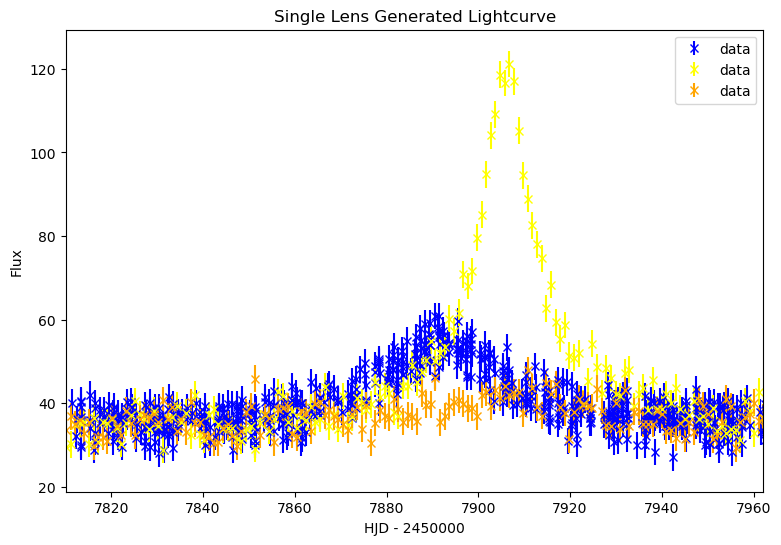

In [34]:
from typing import Tuple, Callable, Optional, List

def generate_lightcurve(
                        magnification: Callable[[np.ndarray], np.ndarray],
                        u0: float,
                        t0: float,
                        tE: float,
                        dbbinary: float,
                        dt: float,
                        FS1: float,
                        FS2: float,
                        FB: float,
                        sig: np.ndarray,
                        t: Optional[np.ndarray] = None,
                        trange: Optional[Tuple[float, float]] = None
                        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate lightcurve for given parameters and epochs or date range.

    Parameters
    ----------
    SL_magnification : Callable[[float, float, float, np.ndarray], np.ndarray]
        Single lens magnification function.
    u0 : float
        Impact parameter.
    t0 : float
        Time of closest approach.
    tE : float
        Einstein radius crossing time.
    dbbinary : float
        Binary separation.
    dt : float
        Binary separation.
    FS1 : float
        Primary source flux.
    FS2 : float
        Secondary source flux.
    FB : float
        Blend flux.
    sig : np.ndarray
        Standard deviation of Gaussian errors.
    t : Optional[np.ndarray], optional
        Array of epochs (default is None).
    trange : Optional[Tuple[float, float]], optional
        Date range (default is None).
        - tstart : float, start of date range.
        - tfinish : float, end of date range.

    Returns
    -------
    t_data : np.ndarray
        Generated time points.
    flux_data : np.ndarray
        Generated flux data with noise.
    flux_err_data : np.ndarray
        Gaussian errors.

    Raises
    ------
    ValueError
        If neither epochs nor date range is provided.
        If u0 or t0 or tE are not floats.
    """
    if np.isnan(FB):
        FB = 0.0
    if not isinstance(u0, float):
        print(f'u0 = {u0}')
        raise ValueError('u0 must be a float.')
    if not isinstance(t0, float):
        print(f't0 = {t0}')
        raise ValueError('t0 must be a float.')
    if not isinstance(tE, float):
        print(f'tE = {tE}')
        raise ValueError('tE must be a float.')
    if not isinstance(dbbinary, float):
        print(f'dbbinary = {dbbinary}')
        raise ValueError('dbbinary must be a float.')
    if not isinstance(dt, float):
        print(f'dt = {dt}')
        raise ValueError('dt must be a float.')
    if not isinstance(FS1, float):
        print(f'FS1 = {FS1}')
        raise ValueError('FS1 must be a float.')
    if not isinstance(FS2, float):
        print(f'FS2 = {FS2}')
        raise ValueError('FS2 must be a float.')
    if not isinstance(FB, float):
        print(f'FB = {FB}')
        raise ValueError('FB must be a float.')

    # Generate epochs if not provided
    if t is None:
        if trange is None:
            raise ValueError('Either epochs or date range must be provided.')
        tstart, tfinish = trange
        days = np.arange(np.floor(tstart), np.ceil(tfinish)) # Generate integer days within the range
        t = []
        for day in days:
            if tstart <= day <= tfinish:
                # Generate epochs for the night
                num_epochs = np.random.randint(0, 9)  # Random number of epochs between 0 and 8
                epochs = np.random.choice(np.arange(0.3, 0.6, 0.0104167), size=num_epochs, replace=False)
                t.extend(day + epochs)
    t = np.array(t)

    # Generate the trajectory
    tau = (t0 - t)/tE
    ut = u_t(tau, u0) # primary source trajectory

    u0_binary = u0 + dbbinary
    t0_binary = t0 + dt
    tau_binary = (t0_binary - t)/tE
    ut_binary = u_t(tau_binary, u0_binary)  # binary source trajectory

    # Generate theoretical flux

    A1 = magnification(ut)
    A2 = magnification(ut_binary)

    flux_theoretical = A1*FS1 + A2*FS2 + FB

    # Generate Gaussian noise
    noise = np.random.normal(0, sig, size=t.shape)

    # Generate noisy flux data
    flux_data = flux_theoretical + noise

    # Gaussian errors
    flux_err_data = np.full(t.shape, sig)

    return t, flux_data, flux_err_data


# making up event parameters and data stats
sig = 3.2  # figure out good numbers for this
u0 = 0.4321
t0 = 7892.123
tE = 23.4
dbbinary = 0.5
dt = 0.5
FS1 = 10.0
FS2 = 15.0
FB = 10.0

trange = (t0-82, t0+70)

# generating fake Earth data
t_data, flux_data, flux_err_data = generate_lightcurve(magnification, u0, t0, tE, dbbinary, dt, FS1, FS2, FB, sig, trange=trange)

# generate fake Spitzer data
sig_spitzer = 10.5  # get a real number for this
FS1 = 10.0
FS2 = 15.0
FB = 10.0
t_spitzer_data = np.linspace(trange[0], trange[1], int(trange[1]-trange[0]))  # once per day
db = d_beta(8500*parsec, 1*AU, einstein_radius(0.2*M_sol, 7000*parsec, 8500*parsec))
dt = d_tau(8500*parsec, 1*AU, einstein_radius(0.2*M_sol, 7000*parsec, 8500*parsec))
u0_spitzer_1, u0_spitzer_2 = impact_parameter_spitzer(u0, db)
t0_spitzer = t0 + dt*tE
t_spitzer, flux_spitzer1, flux_err_spitzer1 = generate_lightcurve(
    magnification,
    u0_spitzer_1,
    t0_spitzer,
    tE,
    dbbinary,
    dt,
    FS1,
    FS2,
    FB,
    sig,
    t = t_spitzer_data
)
t_spitzer, flux_spitzer2, flux_err_spitzer2 = generate_lightcurve(
    magnification,
    u0_spitzer_2,
    t0_spitzer,
    tE,
    dbbinary,
    dt,
    FS1,
    FS2,
    FB,
    sig,
    t = t_spitzer_data
)


# Let's start by taking a look at the data
plt.close(1)
plt.figure(figsize=(9,6), num=1)
plt.errorbar(t_data, flux_data, yerr=flux_err_data, fmt='x', color='blue', label='data')
plt.errorbar(t_spitzer, flux_spitzer1, yerr=flux_err_spitzer1, fmt='x', color='yellow', label='data')
plt.errorbar(t_spitzer, flux_spitzer2, yerr=flux_err_spitzer2, fmt='x', color='orange', label='data')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.title('Single Lens Generated Lightcurve')
plt.xlim(trange[0], trange[1])
#plt.xlim(t0-2, t0+2)
plt.legend()
plt.show()

In [35]:
def binary_timeshift(d_binary, ds, phi_binary, er):
  """
  Calcuate the difference in peak times between the primary and secondary sources.

  Inputs
  ------
  d_binary: distance between the two sources in AU
  ds: distance to the primary source in parsecs
  phi_binary: angle of binary separation in degrees
  er: Einstein radius in meters

  Returns
  -------
  dt_binary: difference in peak times in seconds
  """
  beta_binary = (d_binary/ds)/er
  dt_binary = beta_binary*np.cos(phi_binary)

  return dt_binary

In [36]:
try:
    import MulensModel as mm
except ModuleNotFoundError:
    !pip install MulensModel
    import MulensModel as mm

In [37]:
finite_source_methods = [
    # Uniform source
    'finite_source_uniform_Gould94',               # 0, 10E-3 < rho < 1 (has a bug)
    'finite_source_uniform_Gould94_direct',        # 1, 10E-3 < rho < 1
    'finite_source_uniform_WittMao94',             # 2, rho < 0.01
    'finite_source_uniform_Lee09',                 # 3, rho > 0.01

    # Limb-darkened source
    'finite_source_LD_WittMao94',                  # 4, rho < 0.01
    'finite_source_LD_Yoo04',                      # 5, 10E-3 < rho < 1
    'finite_source_LD_Yoo04_direct',               # 6, 10E-3 < rho < 1
    'finite_source_LD_Lee09'                       # 7, rho > 0.01
]

# objective function
def binary_source_chi2(theta: np.ndarray,
                       model1: mm.Model,
                       model2: mm.Model,
                       data: List,
                       verbose: Optional[bool] = False,
                       return_fluxes: Optional[bool] = False,
                       FS1 = None,
                       FS2 = None,
                       FB = None
                       ) -> float:
    """
    chi2 function for a binary-source, single-lens, microlensing model.

    Parameters
    ----------
    theta : np.ndarray
        Array of model parameters being fit.
    model1 : mm.Model
        Primary source model.
    model2 : mm.Model
        Secondary source model.
    data : list
        List of data arrays.
    verbose : bool, optional
        Default is False.
        Print the primary source flux, secondary source flux, and blend flux.
    FS1 : float, optional
        Primary source flux. If provided, will be used in the model.
    FS2 : float, optional
        Secondary source flux. If provided, will be used in the model.
    FB : float, optional
        Blend flux. If provided, will be used in the model.

    Returns
    -------
    float
        The chi2 value.

    Notes
    -----
    The model parameters are unpacked from theta and set to the model1 and model2 parameters.
    model1 and model2 are MulensModel.Model objects; see MulensModel documentation
    (https://rpoleski.github.io/MulensModel/) for more information.
    """
    # Unpack the data
    t, flux, flux_err = data

    # Model parameters being fit
    labels = ['t_0', 'u_0', 't_E']

    # Change the values of model.parameters to those in theta
    theta1 = theta[:3]
    theta2 = theta[3:]
    for (label, value1, value2) in zip(labels, theta1, theta2):
        setattr(model1.parameters, label, value1)
        setattr(model2.parameters, label, value2)

    # Calculate the model magnification for each source
    A1 = model1.get_magnification(t)
    A2 = model2.get_magnification(t)

    # Determine which fluxes need to be fitted
    fit_FS1 = FS1 is None
    fit_FS2 = FS2 is None
    fit_FB = FB is None
    
    # Create lists of known and unknown flux components
    known_fluxes = {}
    unknown_components = []
    
    if not fit_FS1:
        known_fluxes['FS1'] = FS1
    else:
        unknown_components.append('FS1')
        
    if not fit_FS2:
        known_fluxes['FS2'] = FS2
    else:
        unknown_components.append('FS2')
        
    if not fit_FB:
        known_fluxes['FB'] = FB
    else:
        unknown_components.append('FB')

    # If all fluxes are provided, no fitting needed
    if not unknown_components:
        model_flux = A1 * FS1 + A2 * FS2 + FB
        chi2 = np.sum(((flux - model_flux) / flux_err)**2)
        
        if return_fluxes:
            return chi2, FS1, FS2, FB
        else:
            return chi2

    # Calculate residual flux after subtracting known components
    residual_flux = flux.copy()
    if 'FS1' in known_fluxes:
        residual_flux -= known_fluxes['FS1'] * A1
    if 'FS2' in known_fluxes:
        residual_flux -= known_fluxes['FS2'] * A2
    if 'FB' in known_fluxes:
        residual_flux -= known_fluxes['FB']

    # Build design matrix and RHS vector for unknown components
    n_unknown = len(unknown_components)
    design_matrix = np.zeros((n_unknown, n_unknown))
    rhs_vector = np.zeros(n_unknown)
    
    # Weights for weighted least squares
    weights = flux_err**-2
    
    for i, comp_i in enumerate(unknown_components):
        # Get the coefficient vector for component i
        if comp_i == 'FS1':
            coeff_i = A1
        elif comp_i == 'FS2':
            coeff_i = A2
        else:  # comp_i == 'FB'
            coeff_i = np.ones_like(flux)
            
        # Right-hand side vector
        rhs_vector[i] = np.sum(coeff_i * residual_flux * weights)
        
        for j, comp_j in enumerate(unknown_components):
            # Get the coefficient vector for component j
            if comp_j == 'FS1':
                coeff_j = A1
            elif comp_j == 'FS2':
                coeff_j = A2
            else:  # comp_j == 'FB'
                coeff_j = np.ones_like(flux)
                
            # Design matrix element
            design_matrix[i, j] = np.sum(coeff_i * coeff_j * weights)

    # Solve the linear system
    try:
        fitted_values = np.linalg.solve(design_matrix, rhs_vector)
    except np.linalg.LinAlgError:
        # Handle singular matrix: return a large chi2 value
        return 1e16

    # Assign the fitted values back to the appropriate variables
    result_fluxes = {'FS1': FS1, 'FS2': FS2, 'FB': FB}
    for i, component in enumerate(unknown_components):
        result_fluxes[component] = fitted_values[i]
    
    FS1_final = result_fluxes['FS1']
    FS2_final = result_fluxes['FS2'] 
    FB_final = result_fluxes['FB']

    # Print the flux parameters
    if verbose:
        print(f"Primary source flux: {FS1_final}")
        print(f"Secondary source flux: {FS2_final}")
        print(f"Blend flux: {FB_final}")

    # Calculate the model flux and chi2
    model_flux = A1 * FS1_final + A2 * FS2_final + FB_final
    chi2 = np.sum(((flux - model_flux) / flux_err)**2)
    
    # In case something goes wrong with the linear algebra
    if np.isnan(chi2) or np.isinf(chi2):
        print(f"NaN or inf encountered in chi2 calculation: theta={theta}, chi2={chi2}")
        return 1e16

    if return_fluxes:
        return chi2, FS1_final, FS2_final, FB_final
    else:
        return chi2

In [40]:
# Checking the binary_source functions
FS1 = 10.0
FS2 = 15.0
FB = 10.0
theta = np.array([t0, u0, tE, t0+dt, u0+dbbinary, tE])  # initial guess for parameters

earth_data = [t_data, flux_data, flux_err_data]

# MulensModel Objects
pspl_primary = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
pspl_secondary = mm.Model({'t_0': t0+dt, 'u_0': u0+dbbinary, 't_E': tE})

# initial chi2 value (will print the fluxes)
chi2, FS1_fitted, FS2_fitted, FB_fitted = binary_source_chi2(theta, pspl_primary, pspl_secondary, earth_data, verbose=True, return_fluxes=True)

print(f"chi^2 = {chi2}")
print(f"n = {len(t_data)}")
print(f"ndof = {len(t_data) - len(theta)}")
print(f"reduced chi^2 = {chi2 / (len(t_data) - len(theta))}")
print(f"Primary source flux true: {FS1}")
print(f"Secondary source flux true: {FS2}")
print(f"Blend flux true: {FB}")

def percent_check(true_value, fitted_value, percentage_threshold=10.0):
    """
    Check if the fitted value is within a certain percentage of the true value.
    """
    return np.abs(fitted_value - true_value) < percentage_threshold / 100 * true_value

# check that the reduced chi2 and flux parameters are within the acceptable range
if not percent_check(chi2 / (len(t_data) - len(theta)), 1.0):
    raise ValueError("Reduced chi^2 is not within the acceptable range.")

if not percent_check(FS1, FS1_fitted):
    raise ValueError("Primary source flux is not within the acceptable range.")

if not percent_check(FS2, FS2_fitted):
    raise ValueError("Secondary source flux is not within the acceptable range.")

if not percent_check(FB, FB_fitted):
    raise ValueError("Blend flux is not within the acceptable range.")

Primary source flux: 9.28703976941313
Secondary source flux: 15.931699672650682
Blend flux: 9.769685982597208
chi^2 = 620.8979713921764
n = 631
ndof = 625
reduced chi^2 = 0.9934367542274822
Primary source flux true: 10.0
Secondary source flux true: 15.0
Blend flux true: 10.0


If the flux values are similar and reduced $\chi^2$ is near 1, then the binary_source_chi2 seems to be working.

## Fitting Functioms

In [102]:
def flat_line_fit(data):
  """
  Fit a flat line to the data and return the chi2 value and best-fit flux. The fit is 
  initialized by the mean flux in the data array

  Parameters
  ----------
  data : tuple
      A tuple containing the time, flux, and flux error arrays.

  Returns
  -------
  chi2 : float
      The chi-squared value of the best-fit model.
  best_flux : float
      The best-fit flux level of the flat line.
  """
  t, flux, flux_err = data

  def chi2_flat(F, data):
    """
    Chi2 function for a flat line model.

    Parameters
    ----------
    F : float
        The flux level of the flat line.
    data : tuple
        A tuple containing the time, flux, and flux error arrays.

    Returns
    -------
    chi2 : float
        The chi-squared value of the model.
    """
    t, flux, flux_err = data
    if F < 0:
        penalty = ((F / 50)**2)
    else:
        penalty = 0
    chi2 = np.sum(((flux - F) / flux_err)**2)

    return chi2

  chi2_initial = chi2_flat(np.mean(flux), data)

  # Minimize using Nelder-Mead
  result = minimize(chi2_flat, np.mean(flux), args=(data,), method='Nelder-Mead')

  # Calculate best chi2
  F_best = result.x[0]
  chi2 = chi2_flat(F_best, data)

  return chi2, F_best

In [103]:
def single_source_fit(data, theta0, t0_ref=0.0):
  """
  Fit a single-lens, single-source model to the data.

  Parameters
  ----------
  data : tuple
      A tuple containing the time, flux, and flux error arrays.
  theta0 : list
      Initial guess for the model parameters [u0, t0, tE, FS, FB].
  t0_ref : float
      Reference time for the model.

  Returns
  -------
  chi2 : float
      The chi-squared value of the best-fit model.
  best_params : list
      The best-fit model parameters [u0, t0, tE, FS, FB].
  """
  t, flux, flux_err = data

  def chi2_single(theta, data, t0_ref):
    """
    Chi2 function for a single-lens, single-source model.

    Parameters
    ----------
    theta : list
        Model parameters [u0, t0, tE, FS, FB].
    data : tuple
        A tuple containing the time, flux, and flux error arrays.
    t0_ref : float
        Reference time for the model.

    Returns
    -------
    chi2 : float
        The chi-squared value of the model.
    """
    t, flux, flux_err = data
    u0, t0, tE, FS, FB = theta
    tau = (t0-t)/tE
    ut = u_t(tau, u0)
    A = magnification(ut)
    F = FS*A + FB
    
    if FB < 0:
        penalty = ((FB / 50)**2)
    else:
        penalty = 0
      
    penalty += (((t0_ref -t0) / 5)**2)
    
    chi2 = np.sum(((flux - F) / flux_err)**2) + penalty

    return chi2

  chi2_initial = chi2_single(theta0, data, t0_ref)

  # Minimize using Nelder-Mead
  result = minimize(chi2_single, theta0, args=(data, t0_ref,), method='Nelder-Mead')

  # Calculate best chi2
  u0_best, t0_best, tE_best, FS_best, FB_best = result.x
  chi2 = chi2_single([u0_best, t0_best, tE_best, FS_best, FB_best], data, t0_ref)

  return chi2, [u0_best, t0_best, tE_best, FS_best, FB_best]

## Spitzer lc Detectable

In [ ]:
# remake spitzer_detectable with fits
import numpy as np
import matplotlib.pyplot as plt
import math

def Spitzer_lc_detectable(
    ml, dl, ds, u0_earth, phis, phi_binary, d_binary,
    tE,
    FS1_I, FS2_I, FB_I,
    FS1_L, FS2_L, FB_L
    ):

    """

    Tags a cell Spitzer-only detectable if a source is only microlensed as seen
    from Spitzer.

    Inputs:
    ml: mass of the lens in solar masses
    ds: distance to the primary source in parsecs
    dl: distance to the lens in parsecs
    u0_earth: u0 of the event as seen from Earth in units of Einstein radius
    phis: angle between Earth and Spitzer in degrees
    phi_binary: angle of binary separation in degrees
    d_binary: distance between the two sources in AU
    tE: Einstein radius crossing time (days)
    FS1_I: flux of the primary source seen from Earth
    FS2_I: flux of the secondary source seen from Earth
    FB_I: flux of the blend seen from Earth
    FS1_L: flux of the primary source seen from Spitzer
    FS2_L: flux of the secondary source seen from Spitzer
    FB_L: flux of the blend seen from Spitzer

    Returns whether or not the secondary source appears lensed from Spitzer only.

    Raises:
    ValueError: If any of the input parameters are not of the correct type.
    """
    # type checks
    #------------
    float_params = {"ml": ml, "dl": dl, "ds": ds, "u0_earth": u0_earth,
                    "phi_binary": phi_binary, "d_binary": d_binary, "tE": tE,
                    "FS1_I": FS1_I, "FS2_I": FS2_I, "FB_I": FB_I,
                    "FS1_L": FS1_L, "FS2_L": FS2_L, "FB_L": FB_L}
    for param, value in float_params.items():
        if not (np.isscalar(value) and np.isreal(value)):
            print(f'{param} = {value}')
            raise ValueError(f'{param} must be a real scalar number (i.e., a float).')
        
    print(f'phis = {phis}')
    if not isinstance(phis, np.ndarray):
        raise ValueError('phis must be a numpy array.')

    # constants
    #------------
    t0 = 0.0
    parsec = 3.086e16
    lightyear = 9.461e15
    AU = 1.5e11
    M_sol = 2e30
    g = 6.6743e-11  # Gravitational constant
    c = 299792458  # Speed of light in m/s
    k = 4*g/(c**2)

    # unit conversions to SI units
    #-----------------------------
    ml_si = ml*M_sol #converts to kg
    ds_si = ds*parsec #converts to m
    dl_si = dl*parsec
    d_binary_si = d_binary*AU #converts to m
    phi_binary_rad = phi_binary * np.pi / 180 #converts to radians
    phis_rad = phis * np.pi / 180

    # event scaling
    #--------------
    er = np.sqrt(ml_si*k*((ds_si-dl_si)/(dl_si*ds_si))) # in meters...
    # print(ml, k, ds, dl)
    # 4.0000000000000004e+29 2.9704641076474662e-27 1.543e+20 2.6231e+20

    # initializing storage parameters
    #--------------------------------
    is_Spitzer_only_detectable = np.zeros((len(phis), 5))
    letters_array = []
    import pandas as pd
    params = pd.DataFrame(columns=[
        "F_best",
        "F_best_Spitzer",
        "best1_u0", "best1_t0", "best1_tE", "best1_fs", "best1_fb",
        "best2_u0", "best2_t0", "best2_tE", "best2_fs", "best2_fb",
        "best1Spitzer_u0", "best1Spitzer_t0", "best1Spitzer_tE", "best1Spitzer_fs", "best1Spitzer_fb",
        "best2Spitzer_u0", "best2Spitzer_t0", "best2Spitzer_tE", "best2Spitzer_fs", "best2Spitzer_fb",
        "chi2_earth_flat",
        "chi2_earth_binary",
        "chi2_earth_single1",
        "chi2_earth_single2",
        "chi2_spitzer_flat",
        "chi2_spitzer_binary1",
        "chi2_spitzer_single1",
        "chi2_spitzer_single2",
        "phi", "ml", "dl", "ds", "u0_earth", "phi_binary", "d_binary", "tE", "FS1_I", "FS2_I", "FB_I", "FS1_L", "FS2_L", "FB_L",
        "name", "u0_earth_s2", "u0_spitzer_s1", "u0_spitzer_s2"
    ])

    # Loop over each angle
    for i, phi_rad in enumerate(phis_rad):
        d_perp = np.sin(phi_rad) *1*AU
        # print(d_perp)

        #1500000000.0
        #1500000000.0 [2.57667914e+20] [4.14135297e-09] [0.00140569]
        #dt = [1.60383934e-09]

        #d_par = np.cos(phi) *1.*AU

        db = (d_perp/ds_si)/er
        # print(d_perp, ds, er, db)
        # 106066017177.98212 1.543e+20 nan nan
        u0_spitzer_s1 = u0_earth + db

        beta_binary = (d_binary_si/ds_si)/er
        db_binary = beta_binary*np.sin(phi_binary_rad)
        #print(db_binary)

        u0_earth_s1 = u0_earth
        u0_earth_s2 = u0_earth_s1 + db_binary
        u0_spitzer_s2 = u0_spitzer_s1 + db_binary

        # Calculate t0
        # db = d_beta(ds*parsec, d_binary*AU, er)
        # dt = d_tau(ds*parsec, d_binary*AU, er)*tE
        # t0_spitzer = t0 + dt

        t02_earth = 0.0 + binary_timeshift(d_binary, ds, phi_binary, er)
        t0_spitzer_s1 = t0 + binary_timeshift(1*AU, ds, phis[i], er) # Assuming 1 AU distance for Spitzer from Earth
        t02_spitzer_s2 = t0_spitzer_s1 + binary_timeshift(d_binary, ds, phi_binary, er)

        # Generate the fake data
        trange = (-75.0, 75.0)
        sig_I = 10.5 # get a better number for this
        # global earth_data
        earth_data = generate_lightcurve(
            magnification,
            u0_earth_s1,
            t0,
            tE,
            db_binary,
            t02_earth - t0,
            FS1_I,
            FS2_I,
            FB_I,
            sig_I,
            trange=trange
        )
        # global spitzer_data
        spitzer_data = generate_lightcurve(
            magnification,
            u0_spitzer_s1,
            t0_spitzer_s1,
            tE,
            db_binary,
            t02_spitzer_s2 - t0_spitzer_s1,
            FS1_L,
            FS2_L,
            FB_L,
            sig_I,
            trange=trange
        )
        if np.isnan(FB_L):
            FB_L = 0.0
        if np.isnan(FB_I):
            FB_I = 0.0

        name = f"_{phi_rad*180/np.pi}_{ml}_{dl}_{ds}_{u0_earth}_{phi_binary}_{d_binary}_{tE}.npy"
        if not os.path.exists("data/lightcurves"):
            os.makedirs("data/lightcurves")
        np.save(f"data/lightcurves/earth_data{name}", earth_data)
        np.save(f"data/lightcurves/spitzer_data{name}", spitzer_data)

        print(u0_spitzer_s1, t0_spitzer_s1, tE, db_binary, t02_spitzer_s2 - t0_spitzer_s1, FS1_L, FS2_L, FB_L, sig_I)

        # MulensModels
        pspl_earth = mm.Model({'t_0': t0, 'u_0': u0_earth_s1, 't_E': tE})
        pspl_spitzer1 = mm.Model({'t_0': t0_spitzer_s1, 'u_0': u0_spitzer_s1, 't_E': tE})
        pspl_earth_binary = mm.Model({'t_0': t02_earth, 'u_0': u0_earth_s2, 't_E': tE})
        pspl_spitzer1_binary = mm.Model({'t_0': t02_spitzer_s2, 'u_0': u0_spitzer_s2, 't_E': tE})

        # Fitting a flat line to check that the models are significantly preferred to it
        #------------------------------------------------------------------------------
        # Detactability criteria of Deltachi2>500
        chi2_earth_flat, F_best = flat_line_fit(earth_data)
        chi2_spitzer_flat, F_best_Spitzer = flat_line_fit(spitzer_data)

        # Fitting single source models to see if the binary-source model is significantly preferred
        #------------------------------------------------------------------------------------------
        # initial guesses for single source fits
        theta_earth1_guess = np.array([u0_earth_s1, t0, tE, FS1_I, FB_I + FS2_I])
        theta_earth2_guess = np.array([u0_earth_s2, t02_earth, tE, FS2_I, FB_I + FS1_I])
        theta_spitzer1_guess = np.array([u0_spitzer_s1, t0_spitzer_s1, tE, FS1_L, FB_L + FS2_L])
        theta_spitzer2_guess = np.array([u0_spitzer_s2, t02_spitzer_s2, tE, FS2_L, FB_L + FS1_L])
        
        # earth fits starting from each source individualy and constraining the fit to "t0" near the 
        # reference t0 for that source and perspective
        chi2_earth_single1, best1 = single_source_fit(earth_data, theta_earth1_guess, t0_ref=t0)
        chi2_earth_single2, best2 = single_source_fit(earth_data, theta_earth2_guess, t0_ref=t02_earth)

        # Spitzer fits starting from each source individually and constraining the fit to "t0" near the
        # reference t0 for that source and perspective
        chi2_spitzer_single1, best1Spitzer = single_source_fit(spitzer_data, theta_spitzer1_guess, t0_ref=t0_spitzer_s1)
        chi2_spitzer_single2, best2Spitzer = single_source_fit(spitzer_data, theta_spitzer2_guess, t0_ref=t02_spitzer_s2)

        # Evaluating chi2 for the true params binary source model
        #---------------------------------------------------------
        theta_earth = np.array([t0, u0_earth_s1, tE, t02_earth, u0_earth_s2, tE])
        theta_spitzer1 = np.array([t0_spitzer_s1, u0_spitzer_s1, tE, t02_spitzer_s2, u0_spitzer_s2, tE])

        # calculating chi2 using true flux parameters
        chi2_earth_binary = binary_source_chi2(theta_earth, pspl_earth, pspl_earth_binary, earth_data, verbose=False, FS1=FS1_I, FS2=FS2_I, FB=FB_I)
        chi2_spitzer_binary1 = binary_source_chi2(theta_spitzer1, pspl_spitzer1, pspl_spitzer1_binary, spitzer_data, verbose=False, FS1=FS1_L, FS2=FS2_L, FB=FB_L)

        # # calculating chi2 using fitted flux parameters
        # chi2_earth_binary = binary_source_chi2(theta_earth, pspl_earth, pspl_earth_binary, earth_data, verbose=False)
        # chi2_spitzer_binary1 = binary_source_chi2(theta_spitzer1, pspl_spitzer1, pspl_spitzer1_binary, spitzer_data, verbose=False)
        
        # Storing the parameters in a dataframe
        params_new_dict = {
            "F_best": F_best,
            "F_best_Spitzer": F_best_Spitzer,
            "best1_u0": best1[0],
            "best1_t0": best1[1],
            "best1_tE": best1[2],
            "best1_fs": best1[3],
            "best1_fb": best1[4],
            "best2_u0": best2[0],
            "best2_t0": best2[1],
            "best2_tE": best2[2],
            "best2_fs": best2[3],
            "best2_fb": best2[4],
            "best1Spitzer_u0": best1Spitzer[0],
            "best1Spitzer_t0": best1Spitzer[1],
            "best1Spitzer_tE": best1Spitzer[2],
            "best1Spitzer_fs": best1Spitzer[3],
            "best1Spitzer_fb": best1Spitzer[4],
            "best2Spitzer_u0": best2Spitzer[0],
            "best2Spitzer_t0": best2Spitzer[1],
            "best2Spitzer_tE": best2Spitzer[2],
            "best2Spitzer_fs": best2Spitzer[3],
            "best2Spitzer_fb": best2Spitzer[4],
            "chi2_earth_flat": chi2_earth_flat,
            "chi2_earth_binary": chi2_earth_binary,
            "chi2_earth_single1": chi2_earth_single1,
            "chi2_earth_single2": chi2_earth_single2,
            "chi2_spitzer_flat": chi2_spitzer_flat,
            "chi2_spitzer_binary1": chi2_spitzer_binary1,
            "chi2_spitzer_single1": chi2_spitzer_single1,
            "chi2_spitzer_single2": chi2_spitzer_single2,
            "phi": phis[i],
            "ml": ml,
            "dl": dl,
            "ds": ds,
            "u0_earth": u0_earth,
            "phi_binary": phi_binary,
            "d_binary": d_binary,
            "tE": tE,
            "FS1_I": FS1_I,
            "FS2_I": FS2_I,
            "FB_I": FB_I,
            "FS1_L": FS1_L,
            "FS2_L": FS2_L,
            "FB_L": FB_L,
            "name": name,
            "u0_earth_s2": u0_earth_s2,
            "u0_spitzer_s1": u0_spitzer_s1,
            "u0_spitzer_s2": u0_spitzer_s2
        }

        # Append the new parameters to the full DataFrame
        params = pd.concat([params, pd.DataFrame([params_new_dict])], ignore_index=True)

        # plot the lightcurves
        plt.close(100)
        plt.figure(figsize=(10, 5), num=100)
        plt.errorbar(earth_data[0], earth_data[1], yerr=earth_data[2], label='Earth Data', fmt='x', color='black')
        plt.errorbar(spitzer_data[0], spitzer_data[1], yerr=spitzer_data[2], label='Spitzer Data', fmt='o', color='blue')

        # plot the fitted models
        t = np.linspace(-75, 75, 1000)
        tau = (best1[1]-t)/best1[2]
        ut = u_t(tau, best1[0])
        s1_E_model = magnification(ut)
        s1_E_model = best1[3]*s1_E_model + best1[4]
        plt.plot(t, s1_E_model, label='Earth S1 Model', color='black')

        tau = (best2[1]-t)/best2[2]
        ut = u_t(tau, best2[0])
        s2_E_model = magnification(ut)
        s2_E_model = best2[3]*s2_E_model + best2[4]
        plt.plot(t, s2_E_model, label='Earth S2 Model', color='black')
        
        tau = (best1Spitzer[1]-t)/best1Spitzer[2]
        ut = u_t(tau, best1Spitzer[0])
        s1_S_model = magnification(ut)
        s1_S_model = best1Spitzer[3]*s1_S_model + best1Spitzer[4]
        plt.plot(t, s1_S_model, label='Spitzer S1 Model', color='blue')

        tau = (best2Spitzer[1]-t)/best2Spitzer[2]
        ut = u_t(tau, best2Spitzer[0])
        s2_S_model = magnification(ut)
        s2_S_model = best2Spitzer[3]*s2_S_model + best2Spitzer[4]
        plt.plot(t, s2_S_model, label='Spitzer S2 Model', color='cyan')
        
        # plot the truth models
        pspl_earth, pspl_earth_binary = mm.Model({'t_0': t0, 'u_0': u0_earth_s1, 't_E': tE}), mm.Model({'t_0': t02_earth, 'u_0': u0_earth_s2, 't_E': tE})
        # F = FS1_I * A1 + FS2_I * A2 + FB_I
        A1 = pspl_earth.get_magnification(t)
        A2 = pspl_earth_binary.get_magnification(t)
        F = FS1_I * A1 + FS2_I * A2 + FB_I
        plt.plot(t, F, label='Earth Truth Model', color='red')
        
        pspl_spitzer1, pspl_spitzer1_binary = mm.Model({'t_0': t0_spitzer_s1, 'u_0': u0_spitzer_s1, 't_E': tE}), mm.Model({'t_0': t02_spitzer_s2, 'u_0': u0_spitzer_s2, 't_E': tE})
        # F = FS1_L * A1 + FS2_L * A2 + FB_L
        A1 = pspl_spitzer1.get_magnification(t)
        A2 = pspl_spitzer1_binary.get_magnification(t)
        F = FS1_L * A1 + FS2_L * A2 + FB_L
        plt.plot(t, F, label='Spitzer Truth Model', color='blue')

        plt.xlabel('Time (days)')
        plt.ylabel('Flux (/s)')
        plt.title(f'Lightcurves for {name}')
        plt.legend()
        plt.savefig(f"data/lightcurves/lc{name}.png")

        # TODO: check for solution swapping <= It shouln't happen now that I have added a sigma=5days t0_ref prior
        print(f"chi^2 comparison {i}: {chi2_earth_flat}, {chi2_earth_binary}, {chi2_earth_single1}, {chi2_earth_single2}")
        print(f"Spitzer comparison {i}: {chi2_spitzer_flat}, {chi2_spitzer_binary1}, {chi2_spitzer_single1}, {chi2_spitzer_single2}")
        
        # Position key:
        # 0: nothing is detected, 1: S1 is detected from Earth, 2: S2 is detected from Earth, 
        # 3: S1 is detected from Spitzer, 4: S2 is detected from Spitzer
        # Value key: 
        # [0: false/not detectable, 1: true/detectable]

        if ((chi2_earth_flat + chi2_spitzer_flat) - (chi2_earth_binary + chi2_spitzer_binary1)) < 500:              
                                                                     # if the chi2 difference between the flat-line model of the truth
                                                                     # is less than 500, the detection is not statistically significant
            is_Spitzer_only_detectable[i][0] = 1  # nothing is detected
        else:                                                        # if the chi2 difference *is* bigger than 500, detection is significant
            is_Spitzer_only_detectable[i][0] = 0  # something is detected

            if (chi2_earth_single1 - chi2_earth_binary) < 160:       # if the chi2 difference between the primary-only, single-lens model and
                                                                     # the truth is less than 160, the detection of the secondary is not significant
                is_Spitzer_only_detectable[i][1] = 1  # S1 is detected from Earth
                is_Spitzer_only_detectable[i][2] = 0  # S2 is not detected from Earth
                
            elif (chi2_earth_single2 - chi2_earth_binary) < 160:     # if the chi2 difference between the secondary-only, single-lens model and
                                                                     # the truth is less than 160, the detection of the secondary is not significant
                is_Spitzer_only_detectable[i][1] = 0  # S1 is not detected from Earth
                is_Spitzer_only_detectable[i][2] = 1  # S2 is detected from Earth

            else:                                                    # if the chi2 differences between both single-lens models and the truth
                                                                     # are greater than 160, the detection of BOTH sources is significant
                is_Spitzer_only_detectable[i][1] = 1  # S1 is detected from Earth
                is_Spitzer_only_detectable[i][2] = 1  # S2 is detected from Earth

            if (chi2_spitzer_single1 - chi2_spitzer_binary1) < 160:  # if the chi2 difference between the primary-only, single-lens model and
                                                                     # the truth is less than 160, the detection of the secondary is not significant
                is_Spitzer_only_detectable[i][3] = 1  # S1 is detected from Spitzer
                is_Spitzer_only_detectable[i][4] = 0  # S2 is not detected from Spitzer

            elif (chi2_spitzer_single2 - chi2_spitzer_binary1) < 160:  # if the chi2 difference between the secondary-only, single-lens model and
                                                                     # the truth is less than 160, the detection of the secondary is not significant
                is_Spitzer_only_detectable[i][3] = 0  # S1 is not detected from Spitzer
                is_Spitzer_only_detectable[i][4] = 1  # S2 is detected from Spitzer

            else:                                                    # if the chi2 differences between both single-lens models and the truth
                                                                     # are greater than 160, the detection of BOTH sources is significant
                is_Spitzer_only_detectable[i][3] = 1  # S1 is detected from Spitzer
                is_Spitzer_only_detectable[i][4] = 1  # S2 is detected from Spitzer
        # Key:
        # aceg (blue) = S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.
        # adfh (red) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.
        # adeh (green) = S1 detectable from Earth but not Spitzer, S2 not detectable.
        # adfg (yellow) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.
        # adeg (magenta) = S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.
        # acfh (cyan) = S1 detectable from Earth and Spitzer, S2 detectable from Earth only.
        # aceh (orange) = S1 detectable from Earth and Spitzer, S2 not detectable.
        # acfg (purple) = S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer.

        # These are irrelevant, right? I'm putting them in the dictionary anyway just in case.
        # bdfh = S1 not detectable from earth or Spitzer, S2 detectable from earth only.
        # bdeh = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
        # bdfg = S1 not detectable from earth or Spitzer, S2 detectable from Earth and Spitzer.
        # bdeg = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
        # bcfh = S1 not detectable from earth but detectable from Spitzer, S2 detectable from earth only.
        # bceh = S1 not detectable from earth but detectable from Spitzer, S2 not detectable.
        # bceg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Spitzer only.
        # bcfg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Earth and Spitzer.

        # 1: S1 from Earth, 2: S2 Earth, 3: S1 Spitzer, 4: S2 Spitzer
        letters = ""

        if is_Spitzer_only_detectable[i][1] == 1:
            letters = "a"
        else:
            letters = "b"
        if is_Spitzer_only_detectable[i][3] == 1:
            letters += "c"
        else:
            letters += "d"
        if is_Spitzer_only_detectable[i][2] == 0:  # this one is reversed and we are keeping it like that for backwards compatibility
            letters += "e"
        else:
            letters += "f"
        if is_Spitzer_only_detectable[i][4] == 1:
            letters += "g"
        else:
            letters += "h"

        letters_array.append(letters)

    return letters_array, params #Spitzer_detectable_index

#isod = Spitzer_lc_detectable(
#    0.2, 5000, 8500, 0.25, np.linspace(0,360, 360), 45, 1,
#    30.0,
#    10.0, 15.0, 10.0,
#    10.0, 15.0, 10.0
#    )
#print(isod)

# ml, dl, ds, u0_earth, phi, phi_binary, d_binary,
    # tE,
    # FS1_I, FS2_I, FB_I,
    # FS1_L, FS2_L, FB_L

# Key:
# aceg (blue) = S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.
# adfh (red) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.
# adeh (green) = S1 detectable from Earth but not Spitzer, S2 not detectable.
# adfg (yellow) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.
# adeg (magenta) = S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.
# acfh (cyan) = S1 detectable from Earth and Spitzer, S2 detectable from Earth only.
# aceh (orange) = S1 detectable from Earth and Spitzer, S2 not detectable.
# acfg (purple) = S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer.

# These are irrelevant, right? I'm putting them in the dictionary anyway just in case.
# bdfh = S1 not detectable from earth or Spitzer, S2 detectable from earth only.
# bdeh = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bdfg = S1 not detectable from earth or Spitzer, S2 detectable from Earth and Spitzer.
# bdeg = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bcfh = S1 not detectable from earth but detectable from Spitzer, S2 detectable from earth only.
# bceh = S1 not detectable from earth but detectable from Spitzer, S2 not detectable.
# bceg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Spitzer only.
# bcfg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Earth and Spitzer.


#n = 1 # number of samples you want

#Ds = np.sqrt(np.random.uniform(500**2, 8500**2, n)) # in parsecs
#Dl = np.sqrt(np.random.uniform(2000**2, 5000**2, n)) # also in parsecs
#dbinary_array = np.log(np.random.lognormal(40, 1.5, n)) # in AU
#u0_array = np.linspace(-1, 1, 201) # units of einstein radius
#phi_array = np.linspace(0, 180, 181)

#sd = Spitzer_detectable(1.*M_sol, Dl, Ds, u0_array, phi_array, -90, dbinary_array*AU)
#print(sd)

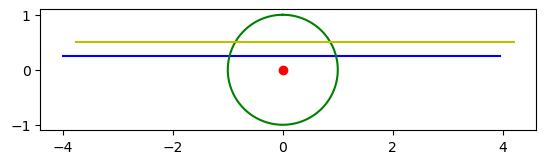

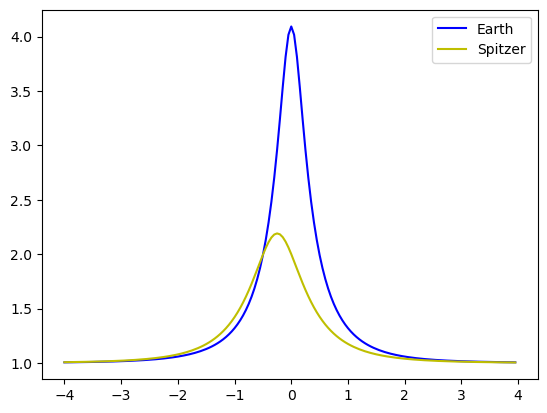

In [124]:
# Plotting magnification and trajectory as seen from Earth and Spitzer using the equations defined above.

ds = 1000*parsec # Converts to meters to plug into function.
dl = 500*parsec
er = einstein_radius(1.*M_sol, dl, ds)
phi = 45 * np.pi / 180 # degrees converted to radians.
d_perp = 1*AU * np.sin(phi) # AU converted to meters.
d_par = 1*AU * np.cos(phi)
u0_earth = 0.25 # theta_E
tau_e = np.arange(-4, 4, 0.05)  # tau (parallel to trajectory) from earth
ut_earth = u_t(tau_e, u0_earth)
tau_ex = tau_e
tau_ey = np.ones_like(tau_e) * u0_earth
circle = np.linspace(0, 2*np.pi, 360)
circle_x = np.sin(circle)
circle_y = np.cos(circle)

db = d_beta(ds, d_perp, er)
dt = d_tau(ds, d_par, er)
tau_spitzer = tau_e + dt

u0_spitzer = u0_earth + db
ut_spitzer = u_t(tau_spitzer, u0_spitzer)

tau_spitzerx = tau_spitzer
tau_spitzery = np.ones_like(tau_spitzer) * u0_spitzer

plt.plot(tau_ex, tau_ey, c="b", label='Earth')
plt.scatter(0,0, c = "r", label='lens')
plt.plot(circle_x, circle_y, c="g", label='Einstein ring')
plt.gca().set_aspect('equal')
plt.plot(tau_spitzerx, tau_spitzery, c="y", label='Spitzer')
#plt.legend()
plt.show()

A_earth = magnification(ut_earth)
A_spitzer = magnification(ut_spitzer)
plt.plot(tau_e, A_earth, c='b', label='Earth')
plt.plot(tau_spitzer-dt, A_spitzer, c='y', label='Spitzer')
plt.legend()
plt.show()

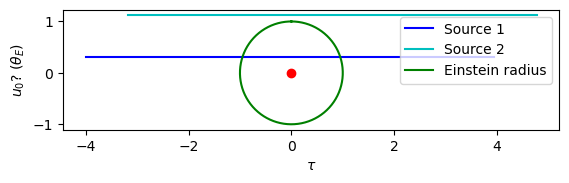

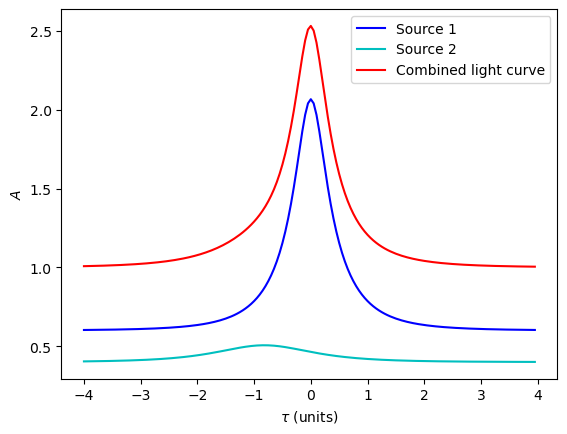

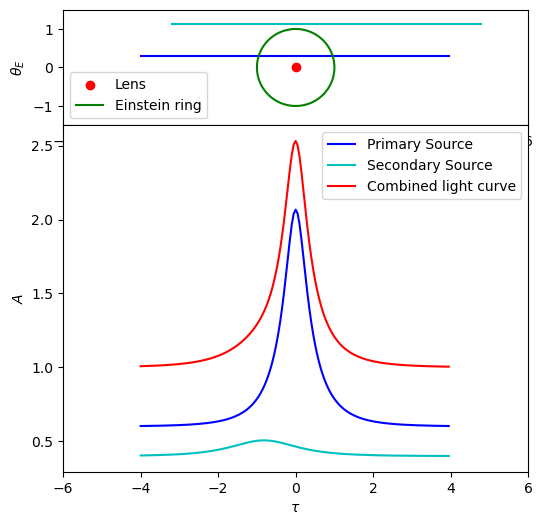

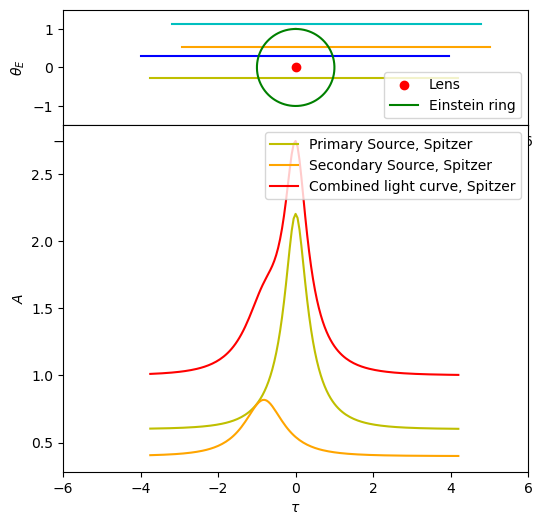

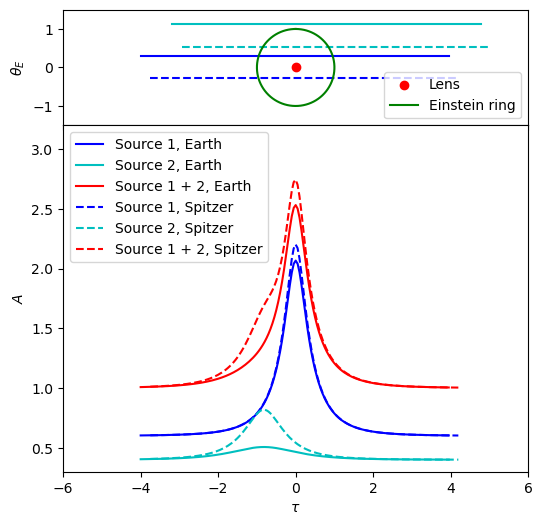

In [76]:
# Plotting trajectory and magnification for both the primary and secondary sources as seen from both Earth and Spitzer; similar to above.

ds = 8500*parsec
dl = 7000*parsec
er = einstein_radius(0.2*M_sol, dl, ds) #ml in solar masses but converted to kg.
phi = -90 * np.pi / 180
d_perp = 1.*AU * np.sin(phi)
d_par = 1.*AU * np.cos(phi)
circle = np.linspace(0, 2*np.pi, 360)
circle_x = np.sin(circle)
circle_y = np.cos(circle)

db = d_beta(ds, d_perp, er)
dt = d_tau(ds, d_par, er)

phi_binary = 45 * np.pi / 180
d_binary = 2*AU
beta_binary = (d_binary/ds)/er
dt_binary = beta_binary*np.cos(phi_binary)
db_binary = beta_binary*np.sin(phi_binary)

u0_earth_s1 = 0.3 #u0_earth
tau_e_s1 = np.arange(-4, 4, 0.05)
ut_earth_s1 = u_t(tau_e_s1, u0_earth_s1)
tau_ex_s1 = tau_e_s1
tau_ey_s1 = np.ones_like(tau_e_s1) * u0_earth_s1

u0_earth_s2 = u0_earth_s1 + db_binary
tau_e_s2 = tau_e_s1 #+ dt_binary
ut_earth_s2 = u_t(tau_e_s2 + dt_binary, u0_earth_s2)
tau_ex_s2 = tau_e_s2 + dt_binary
tau_ey_s2 = np.ones_like(tau_e_s2) * u0_earth_s2

u0_spitzer_s1 = u0_earth_s1 + db
tau_spitzer_s1 = tau_spitzer
ut_spitzer_s1 = u_t(tau_spitzer_s1, u0_spitzer_s1)
tau_spitzerx_s1 = tau_spitzer_s1
tau_spitzery_s1 = np.ones_like(tau_spitzer_s1) * u0_spitzer_s1

u0_spitzer_s2 = u0_spitzer_s1 + db_binary
tau_spitzer_s2 = tau_spitzer_s1 + dt_binary
ut_spitzer_s2 = u_t(tau_spitzer_s2, u0_spitzer_s2)
tau_spitzerx_s2 = tau_spitzer_s2
tau_spitzery_s2 = np.ones_like(tau_spitzer_s2) * u0_spitzer_s2

plt.plot(tau_ex_s1, tau_ey_s1, c="b", label="Source 1")
plt.plot(tau_ex_s2, tau_ey_s2, c="c", label="Source 2")
#plt.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
#plt.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
plt.scatter(0, 0, c = "r")
plt.plot(circle_x, circle_y, c="g", label= "Einstein radius")
plt.gca().set_aspect('equal')
plt.xlabel('$τ$')
plt.ylabel('$u_0$? ($θ_E$)')
plt.legend()
plt.savefig("background_explanation1.png")
plt.show()


A_earth_s1 = magnification(ut_earth_s1)
A_earth_s2 = magnification(ut_earth_s2)
A_earth_binary = 0.6*A_earth_s1 + 0.4*A_earth_s2
A_spitzer_s1 = magnification(ut_spitzer_s1)
A_spitzer_s2 = magnification(ut_spitzer_s2)
A_spitzer_binary = 0.6*A_spitzer_s1 + 0.4*A_spitzer_s2
plt.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Source 1")
plt.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Source 2")
plt.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve")
plt.xlabel('$τ$ (units)')
plt.ylabel('$A$')
#plt.plot(tau_spitzer_s1-dt, A_spitzer_s1, c="y")
#plt.plot(tau_spitzer_s2-dt, A_spitzer_s2, c="orange")
plt.legend()
plt.savefig("background_explanation2.png")
plt.show()
# Mark binaries, angles, lines between. Make plot that explains angles.

fig = plt.figure(1, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
#ax1.gca().set_aspect('equal')
#ax1.set_xlabel('$τ$')
ax1.set_ylabel('$θ_E$')
#plt.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Primary Source")
ax2.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Secondary Source")
ax2.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6, 6)

ax1.legend()
ax2.legend()
plt.subplots_adjust(wspace=0, hspace=0)
 # How do I make it show the legend for the top plot too?
plt.savefig("example_curves_earth.png")
plt.show()

fig = plt.figure(2, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
ax1.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
ax1.set_ylabel('$θ_E$')
ax1.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_spitzer_s1, 0.6*A_spitzer_s1, c="y", label="Primary Source, Spitzer")
ax2.plot(tau_spitzer_s2-dt_binary, 0.4*A_spitzer_s2, c="orange", label="Secondary Source, Spitzer")
ax2.plot(tau_spitzer_s1, A_spitzer_binary, c="r", label="Combined light curve, Spitzer")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6,6)

ax1.legend(loc="lower right")
ax2.legend()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("example_curves_spitzer.png")
plt.show()

# Plotting the view from Earth and Spitzer at the same time for illustrating parameters.
fig = plt.figure(2, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.plot(tau_spitzerx_s1, tau_spitzery_s1, c="b", linestyle="--")
ax1.plot(tau_spitzerx_s2, tau_spitzery_s2, c="c", linestyle="--")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
ax1.set_xticklabels('')
ax1.set_ylabel('$θ_E$')
ax1.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Source 1, Earth")
ax2.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Source 2, Earth")
ax2.plot(tau_e_s1, A_earth_binary, c="r", label="Source 1 + 2, Earth")
ax2.plot(tau_spitzer_s1, 0.6*A_spitzer_s1, c="b", linestyle="--", label="Source 1, Spitzer")
ax2.plot(tau_spitzer_s2-dt_binary, 0.4*A_spitzer_s2, c="c", linestyle="--", label="Source 2, Spitzer")
ax2.plot(tau_spitzer_s1, A_spitzer_binary, c="r", linestyle="--", label="Source 1 + 2, Spitzer")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6,6)
ax2.set_ylim(0.3, 3.2)

ax1.legend(loc="lower right")
ax2.legend(loc="upper left")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("example_curves_both.png", bbox_inches='tight')
plt.show()


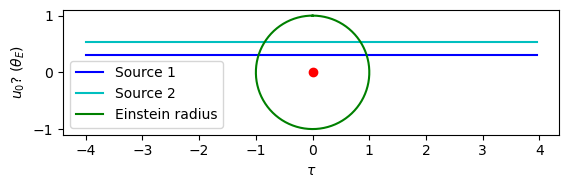

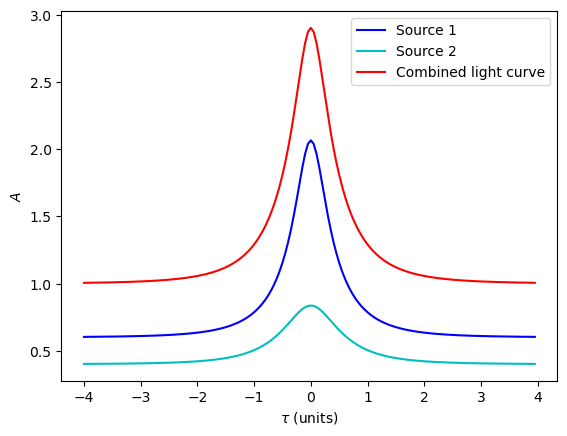

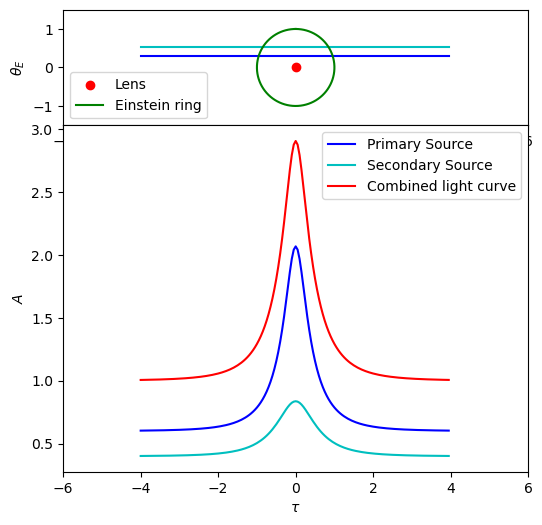

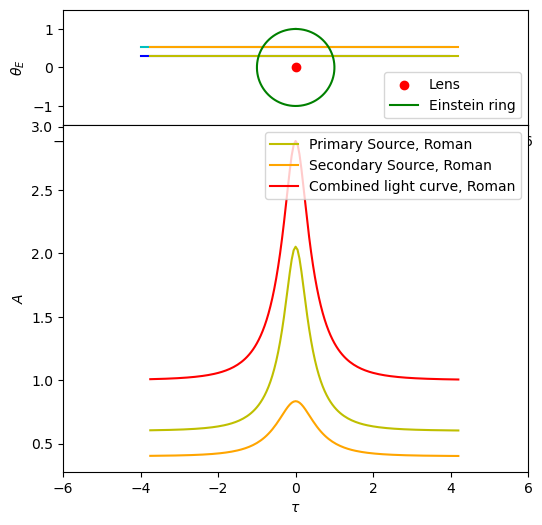

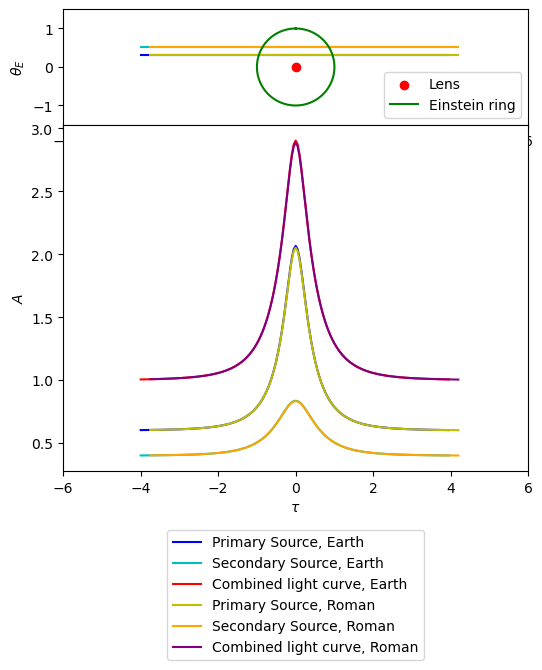

In [77]:
"""
ROMAN NUMBERS
"""

# Plotting trajectory and magnification for both the primary and secondary sources as seen from both Earth and ROMAN; similar to above.

ds = 8000*parsec
dl = 2000*parsec
er = einstein_radius(0.1*M_sol, dl, ds) #ml in solar masses but converted to kg.
phi = 90 * np.pi / 180
d_perp = 0.01*AU * np.sin(phi)
d_par = 0.01*AU * np.cos(phi)
circle = np.linspace(0, 2*np.pi, 360)
circle_x = np.sin(circle)
circle_y = np.cos(circle)

db = d_beta(ds, d_perp, er)
dt = d_tau(ds, d_par, er)

phi_binary = 90 * np.pi / 180
d_binary = 1*AU
beta_binary = (d_binary/ds)/er
dt_binary = beta_binary*np.cos(phi_binary)
db_binary = beta_binary*np.sin(phi_binary)

u0_earth_s1 = 0.3 #u0_earth
tau_e_s1 = np.arange(-4, 4, 0.05)
ut_earth_s1 = u_t(tau_e_s1, u0_earth_s1)
tau_ex_s1 = tau_e_s1
tau_ey_s1 = np.ones_like(tau_e_s1) * u0_earth_s1

u0_earth_s2 = u0_earth_s1 + db_binary
tau_e_s2 = tau_e_s1 #+ dt_binary
ut_earth_s2 = u_t(tau_e_s2 + dt_binary, u0_earth_s2)
tau_ex_s2 = tau_e_s2 + dt_binary
tau_ey_s2 = np.ones_like(tau_e_s2) * u0_earth_s2

u0_spitzer_s1 = u0_earth_s1 + db
tau_spitzer_s1 = tau_spitzer
ut_spitzer_s1 = u_t(tau_spitzer_s1, u0_spitzer_s1)
tau_spitzerx_s1 = tau_spitzer_s1
tau_spitzery_s1 = np.ones_like(tau_spitzer_s1) * u0_spitzer_s1

u0_spitzer_s2 = u0_spitzer_s1 + db_binary
tau_spitzer_s2 = tau_spitzer_s1 + dt_binary
ut_spitzer_s2 = u_t(tau_spitzer_s2, u0_spitzer_s2)
tau_spitzerx_s2 = tau_spitzer_s2
tau_spitzery_s2 = np.ones_like(tau_spitzer_s2) * u0_spitzer_s2

plt.plot(tau_ex_s1, tau_ey_s1, c="b", label="Source 1")
plt.plot(tau_ex_s2, tau_ey_s2, c="c", label="Source 2")
#plt.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
#plt.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
plt.scatter(0, 0, c = "r")
plt.plot(circle_x, circle_y, c="g", label= "Einstein radius")
plt.gca().set_aspect('equal')
plt.xlabel('$τ$')
plt.ylabel('$u_0$? ($θ_E$)')
plt.legend()
plt.savefig("background_explanation1.png")
plt.show()


A_earth_s1 = magnification(ut_earth_s1)
A_earth_s2 = magnification(ut_earth_s2)
A_earth_binary = 0.6*A_earth_s1 + 0.4*A_earth_s2
A_spitzer_s1 = magnification(ut_spitzer_s1)
A_spitzer_s2 = magnification(ut_spitzer_s2)
A_spitzer_binary = 0.6*A_spitzer_s1 + 0.4*A_spitzer_s2
plt.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Source 1")
plt.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Source 2")
plt.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve")
plt.xlabel('$τ$ (units)')
plt.ylabel('$A$')
#plt.plot(tau_spitzer_s1-dt, A_spitzer_s1, c="y")
#plt.plot(tau_spitzer_s2-dt, A_spitzer_s2, c="orange")
plt.legend()
plt.savefig("background_explanation2.png")
plt.show()
# Mark binaries, angles, lines between. Make plot that explains angles.

fig = plt.figure(1, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
#ax1.gca().set_aspect('equal')
#ax1.set_xlabel('$τ$')
ax1.set_ylabel('$θ_E$')
#plt.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Primary Source")
ax2.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Secondary Source")
ax2.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6, 6)

ax1.legend()
ax2.legend()
plt.subplots_adjust(wspace=0, hspace=0)
 # How do I make it show the legend for the top plot too?
plt.savefig("example_curves_earth.png")
plt.show()

fig = plt.figure(2, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
ax1.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
ax1.set_ylabel('$θ_E$')
ax1.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_spitzer_s1, 0.6*A_spitzer_s1, c="y", label="Primary Source, Roman")
ax2.plot(tau_spitzer_s2-dt_binary, 0.4*A_spitzer_s2, c="orange", label="Secondary Source, Roman")
ax2.plot(tau_spitzer_s1, A_spitzer_binary, c="r", label="Combined light curve, Roman")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6,6)

ax1.legend(loc="lower right")
ax2.legend()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("example_curves_spitzer.png")
plt.show()

# Plotting the view from Earth and Spitzer at the same time for illustrating parameters.
fig = plt.figure(2, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
ax1.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
ax1.set_ylabel('$θ_E$')
ax1.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Primary Source, Earth")
ax2.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Secondary Source, Earth")
ax2.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve, Earth")
ax2.plot(tau_spitzer_s1, 0.6*A_spitzer_s1, c="y", label="Primary Source, Roman")
ax2.plot(tau_spitzer_s2-dt_binary, 0.4*A_spitzer_s2, c="orange", label="Secondary Source, Roman")
ax2.plot(tau_spitzer_s1, A_spitzer_binary, c="purple", label="Combined light curve, Roman")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6,6)

ax1.legend(loc="lower right")
ax2.legend(bbox_to_anchor=(0.5, -0.15), loc="upper center")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("example_curves_both.png")
plt.show()


In [78]:
# Returns a string of letters for whether or not the secondary source is detectable
# from Spitzer alone.

import numpy as np
import matplotlib.pyplot as plt
import math

def Spitzer_detectable(ml, dl, ds, u0_earth, phi, phi_binary, d_binary):

    """

    Tags a cell Spitzer-only detectable if a source is only microlensed as seen
    from Spitzer.

    Inputs:
    ml: mass of the lens in solar masses
    ds: distance to the primary source in parsecs
    dl: distance to the lens in parsecs
    u0_earth: u0 of the event as seen from Earth in units of Einstein radius
    phi: angle between Earth and Spitzer in degrees
    phi_binary: angle of binary separation in degrees
    d_binary: distance between the two sources in AU

    Returns whether or not the secondary source appears lensed from Spitzer only.

    """

    parsec = 3.086e16
    lightyear = 9.461e15
    AU = 1.5e11
    M_sol = 2e30

    # unit conversions to SI units.
    ml = ml*M_sol #converts to kg
    ds = ds*parsec #converts to m
    dl = dl*parsec
    d_binary = d_binary*AU #converts to m

    g = 6.6743e-11  # Gravitational constant.
    c = 299792458  # Speed of light in m/s.
    k = 4*g/(c**2)

    phi_binary = phi_binary * np.pi / 180 #converts to radians
    phi = phi * np.pi / 180

    er = np.sqrt(ml*k*((ds-dl)/(dl*ds))) # in meters...

    d_perp = np.sin(phi) *1*AU

    #d_par = np.cos(phi) *1.*AU

    db = (d_perp/ds)/er
    u0_spitzer = u0_earth + db

    beta_binary = (d_binary/ds)/er
    db_binary = beta_binary*np.sin(phi_binary)
    #print(db_binary)

    u0_earth_s1 = u0_earth
    u0_earth_s2 = u0_earth_s1 + db_binary
    u0_spitzer_s1 = u0_earth + db
    u0_spitzer_s2 = u0_spitzer_s1 + db_binary

    # Create individual condition strings/arrays
    cond1 = np.where(np.abs(u0_earth_s1) < 1, "a", "b")
    cond2 = np.where(np.abs(u0_spitzer_s1) < 1, "c", "d")
    cond3 = np.where(np.abs(u0_earth_s2) >= 1, "e", "f")
    cond4 = np.where(np.abs(u0_spitzer_s2) < 1, "g", "h")
    
    # Check if we're dealing with scalar inputs by checking if all intermediate values are scalars
    all_scalars = (np.isscalar(u0_earth_s1) and np.isscalar(u0_earth_s2) and 
                   np.isscalar(u0_spitzer_s1) and np.isscalar(u0_spitzer_s2))
    
    if all_scalars:
        # Extract scalar strings from numpy arrays and concatenate
        is_Spitzer_only_detectable = str(cond1.item()) + str(cond2.item()) + str(cond3.item()) + str(cond4.item())
    else:
        # For array inputs, use numpy's char operations
        is_Spitzer_only_detectable = np.char.add(np.char.add(np.char.add(cond1, cond2), cond3), cond4)
    
    #print(type(is_Spitzer_only_detectable))
    #test = str(is_Spitzer_only_detectable)
    #print(type(test))

    #is_Spitzer_only_detectable = (np.where(abs(u0_earth_s1) < 2, 0, 2) +
                                  #np.where(abs(u0_spitzer_s1) < 2, 0, 2) +
                                  #np.where(abs(u0_earth_s2) >= 2, 0, 2) +
                                  #np.where(abs(u0_spitzer_s2) < 2, 1, 2))

    #print(is_Spitzer_only_detectable_str)

    # Dictionary to assign each output to a number (doesn't like arrays).
    #Spitzer_detectable_outputs = {"adfh":1, "adeh":2,
                                  # "adfg":3, "adeg":4,
                                  # "acfh":5, "aceh":6,
                                  # "acfg":7, "aceg":8,
                                  # "bdfh":9, "bdeh":10,
                                  # "bdfg":11, "bdeg":12,
                                  # "bcfh":13, "bceh":14,
                                  # "bceg":15, "bcfg":16}

    #Spitzer_detectable_index = Spitzer_detectable_outputs[str(is_Spitzer_only_detectable)]

    return is_Spitzer_only_detectable #Spitzer_detectable_index

isod = Spitzer_detectable(1, 3000, np.array([5000,6000,7000,8000])[3], 0.1, 90, 90, 1)
print(isod)

# Key:
# aceg (blue) = S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.
# adfh (red) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.
# adeh (green) = S1 detectable from Earth but not Spitzer, S2 not detectable.
# adfg (yellow) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.
# adeg (magenta) = S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.
# acfh (cyan) = S1 detectable from Earth and Spitzer, S2 detectable from Earth only.
# aceh (orange) = S1 detectable from Earth and Spitzer, S2 not detectable.
# acfg (purple) = S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer.

# These are irrelevant, right? I'm putting them in the dictionary anyway just in case.
# bdfh = S1 not detectable from earth or Spitzer, S2 detectable from earth only.
# bdeh = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bdfg = S1 not detectable from earth or Spitzer, S2 detectable from Earth and Spitzer.
# bdeg = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bcfh = S1 not detectable from earth but detectable from Spitzer, S2 detectable from earth only.
# bceh = S1 not detectable from earth but detectable from Spitzer, S2 not detectable.
# bceg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Spitzer only.
# bcfg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Earth and Spitzer.


#n = 1 # number of samples you want

#Ds = np.sqrt(np.random.uniform(500**2, 8500**2, n)) # in parsecs
#Dl = np.sqrt(np.random.uniform(2000**2, 5000**2, n)) # also in parsecs
#dbinary_array = np.log(np.random.lognormal(40, 1.5, n)) # in AU
#u0_array = np.linspace(-1, 1, 201) # units of einstein radius
#phi_array = np.linspace(0, 180, 181)

#sd = Spitzer_detectable(1.*M_sol, Dl, Ds, u0_array, phi_array, -90, dbinary_array*AU)
#print(sd)

acfg


In [79]:
def Spitzer_detectable_new(ml, dl, ds, u0_spitzer, phi, phi_binary, d_binary):

    """
    Returns whether or not the secondary source appears lensed from Spitzer only,
    based on input of u0 from spitzer instead of u0 from Earth.

    Inputs:
    ml: mass of the lens in solar masses
    ds: distance to the primary source in parsecs
    dl: distance to the lens in parsecs
    u0_spitzer: u0 of the event as seen from Spitzer in units of Einstein radius
    phi: angle between Earth and Spitzer in degrees
    phi_binary: angle of binary separation in degrees
    d_binary: distance between the two sources in AU
    """

    parsec = 3.086e16
    lightyear = 9.461e15
    AU = 1.5e11
    M_sol = 2e30

    # unit conversions to SI units.
    ml = ml*M_sol #converts to kg
    ds = ds*parsec #converts to m
    dl = dl*parsec
    d_binary = d_binary*AU #converts to m

    g = 6.6743e-11  # Gravitational constant.
    c = 299792458  # Speed of light in m/s.
    k = 4*g/(c**2)

    phi_binary = phi_binary * np.pi / 180 #converts to radians
    phi = phi * np.pi / 180

    er = np.sqrt(ml*k*((ds-dl)/(dl*ds))) # in meters...

    d_perp = np.sin(phi) *1*AU

    db = (d_perp/ds)/er
    u0_earth = u0_spitzer - db

    beta_binary = (d_binary/ds)/er
    db_binary = beta_binary*np.sin(phi_binary)
    #print(db_binary)

    u0_earth_s1 = u0_earth
    u0_earth_s2 = u0_earth_s1 + db_binary
    u0_spitzer_s1 = u0_spitzer
    u0_spitzer_s2 = u0_spitzer_s1 + db_binary

    is_Spitzer_only_detectable = (np.where(abs(u0_earth_s1) < 1, 0, 2) +
                                  np.where(abs(u0_spitzer_s1) < 1, 0, 2) +
                                  np.where(abs(u0_earth_s2) >= 1, 0, 2) +
                                  np.where(abs(u0_spitzer_s2) < 1, 1, 2))

    return is_Spitzer_only_detectable

u0_array = np.linspace(-2, 2, 401)
phi_array = np.linspace(0, 180, 181)
dbinary_array = np.arange(0.1, 19.1, 0.1)

test = Spitzer_detectable_new(0.3, 7000, 8500, 0.1, 90, -90, 1)
print(test)

3


(401, 100)
(401, 100) (401, 100)
40100 40100


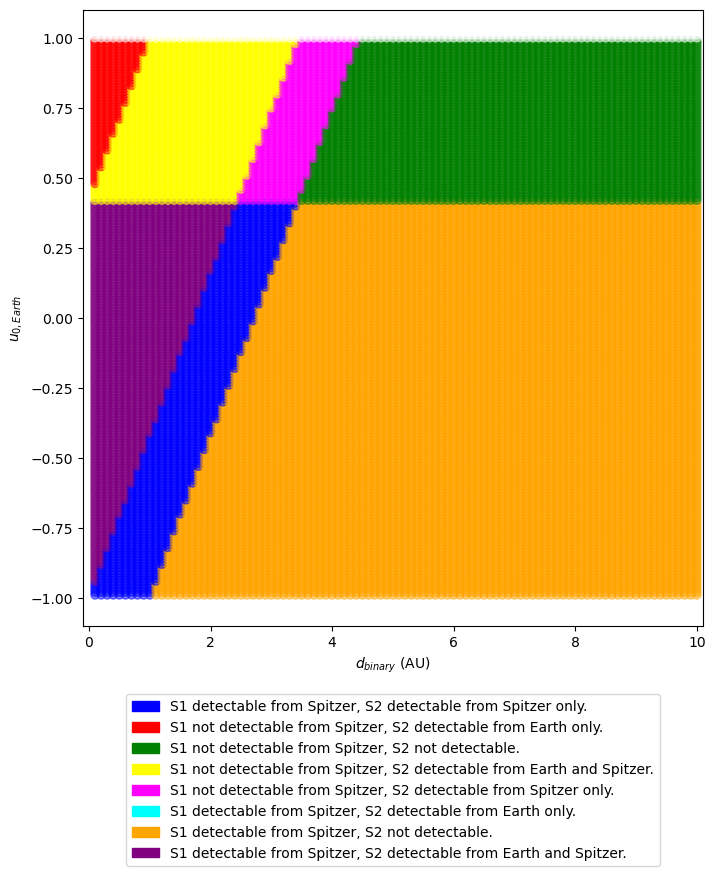

no of blue: 1410
number blue (detectable from Spitzer only) samples: 1410
3.516209476309227 %
number red samples: 257
0.6408977556109726 %
number green (detectable from both Earth and Spitzer) samples: 3545
8.840399002493765 %
number yellow (detectable from Earth only) samples: 1418
3.536159600997506 %
number magenta samples: 580
1.4463840399002494 %
number cyan samples: 0
0.0 %
number orange samples: 11036
27.521197007481298 %
number purple samples: 1654
4.124688279301745 %


In [80]:
# Visualizes the results of the above cell for arrays of data points.
import seaborn as sns

u0_array = np.linspace(-2, 2, 401)  # Units of theta_E
phi_array = np.linspace(0, 180, 181) # degrees
dbinary_array = np.arange(0.1, 10.1, 0.1) #swap to logspace #In AU

#print(len(u0_array))
#print(len(dbinary_array))

n = -90 #phi_binary = 0/360 gives the most blues.

detection_grid = Spitzer_detectable(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)
#detection_grid = Spitzer_detectable_new(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)

#print the shape of detection grid


for i in range(1, len(u0_array)):
    for j in [90]: # 90˚ is max, 0/180˚ is min. So the range for relevant values of phi is 0-180˚.t
        sd = Spitzer_detectable(0.2, 7000, 8500, u0_array[i], j, n, dbinary_array)
        detection_grid = np.vstack((detection_grid, sd))
print(detection_grid.shape)
#for i in range(1, len(u0_array)):
    #for j in [90]: # 90˚ is max, 0/180˚ is min. So the range for relevant values of phi is 0-180˚.
        #sd = Spitzer_detectable_new(0.2, 7000, 8500, u0_array[i], j, n, dbinary_array)
        #detection_grid = np.vstack((detection_grid, sd))

X, Y = np.meshgrid(dbinary_array, u0_array) # To put d_binary in units of thetaE: (np.divide(dbinary_array,einstein_radius(0.2, 7000, 8500)))
print(X.shape, Y.shape)
print(X.size, Y.size)

# colors = np.array(["#000000", "#0072B2", "#999999", "#009E73", "#F0E442", "#CC79A7",
                   # "#56B4E9", "#D55E00", "#E69F00"])

colors = np.array(["black", "blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple", "white", "white", "white", "white",
                   "white", "white", "white"])

#colors = sns.color_palette("colorblind", 9)

# Dictionary to assign each output to a number.
Spitzer_detectable_outputs = {"aceg":1, "adfh":2, "adeh":3, "adfg":4, "adeg":5, "acfh":6,
                              "aceh":7,"acfg":8,  "bdfh":9, "bdeh":10,
                              "bdfg":11, "bdeg":12, "bcfh":13, "bceh":14,
                              "bceg":15, "bcfg":16}

for i in range(len(detection_grid)):
    for j in range(len(detection_grid[0])):
        detection_grid[i,j] = Spitzer_detectable_outputs[detection_grid[i,j]]

numbers = detection_grid.astype(int)
subs_arr = colors[numbers]
#print(subs_arr.shape)
#print(subs_arr.size)

import matplotlib.patches as mpatches

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X.flatten(), Y.flatten(), color = subs_arr.flatten(), alpha = 0.5)
# ax.set_xlim(10e-2,10e1)
# ax.set_xscale("log")
ax.set_xlabel(r'$d_{binary}$ (AU)')
ax.set_ylabel(r'$u_{0,Earth}$')
ax.set_xlim(-0.1, 10.1)
ax.set_ylim(-1.1, 1.1)

blue_patch = mpatches.Patch(color='blue', label="S1 detectable from Spitzer, S2 detectable from Spitzer only.")
red_patch = mpatches.Patch(color='red', label="S1 not detectable from Spitzer, S2 detectable from Earth only.")
green_patch = mpatches.Patch(color='green', label="S1 not detectable from Spitzer, S2 not detectable.")
yellow_patch = mpatches.Patch(color='yellow', label="S1 not detectable from Spitzer, S2 detectable from Earth and Spitzer.")
magenta_patch = mpatches.Patch(color='magenta', label="S1 not detectable from Spitzer, S2 detectable from Spitzer only.")
cyan_patch = mpatches.Patch(color='cyan', label="S1 detectable from Spitzer, S2 detectable from Earth only.")
orange_patch = mpatches.Patch(color='orange', label="S1 detectable from Spitzer, S2 not detectable.")
purple_patch = mpatches.Patch(color='purple', label="S1 detectable from Spitzer, S2 detectable from Earth and Spitzer.")

ax.legend(handles=[blue_patch, red_patch, green_patch, yellow_patch, magenta_patch, cyan_patch,
                   orange_patch, purple_patch], bbox_to_anchor=(0.5, -0.1), loc="upper center")
# ax.text(4, -0.25, "S1 detectable from Earth and Spitzer, \n S2 not detectable.")
# ax.legend([subs_arr==1, subs_arr==2, subs_arr==3,
           # subs_arr==4, subs_arr==5, subs_arr==6,
           # subs_arr==7, subs_arr==8], ["S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.",
            # "S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.",
            # "S1 detectable from Earth but not Spitzer, S2 not detectable.",
            # "S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.",
            # "S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.",
            # "S1 detectable from Earth and Spitzer, S2 detectable from Earth only.",
            # "S1 detectable from Earth and Spitzer, S2 not detectable.",
            # "S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer."])
plt.savefig("parameter_space.png", bbox_inches='tight')
plt.show()


#print(X.shape, Y.shape)
num_dots = X.shape[0] * X.shape[1]  #20100
#print(num_dots)
#print(subs_arr.shape)
# count the number of 1's in detection_grid
#print(detection_grid[1])
#print(numbers.shape)
blues_count = np.where(numbers == 1)[0].size
print('no of blue:', blues_count)

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 1:
            test_count += 1
print('number blue (detectable from Spitzer only) samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 2:
            test_count += 1
print('number red samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 3:
            test_count += 1
print('number green (detectable from both Earth and Spitzer) samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 4:
            test_count += 1
print('number yellow (detectable from Earth only) samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 5:
            test_count += 1
print('number magenta samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 6:
            test_count += 1
print('number cyan samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 7:
            test_count += 1
print('number orange samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 8:
            test_count += 1
print('number purple samples:', test_count)
print(100 * test_count / num_dots, '%')

# To make the model 3D (if this is practical/useful):
# - vertical angle between Earth and Spitzer
# - vertical angle(s) between the observatories and the lens
# - vertical angle(s) between the observatories and the sources
# - vertical angle between the lens and the sources
# - vertical angle between Source 1 and Source 2
# - something to account for motion (observatories, sources, etc.)?

## Get Table

In [81]:
# Generating an SSH key to access private repo
clone = False

# recursively check if the table file already exists
table_file_name = [
    "PopSyCLE-table/data/popsycle_table_with_calcs.csv", 
    "data/popsycle_table_with_calcs.csv", 
    "popsycle_table_with_calcs.csv"
]
if not any(os.path.isfile(f) for f in table_file_name):
    print(f"{table_file_name[2]} does not exist. Generating SSH key...")

    # check if SSH key already exists
    if os.path.isfile("~/.ssh/id_rsa.pub"):
        print("SSH key already exists.")
    else:
        !ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -N ''
        !ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
        !cat ~/.ssh/id_rsa.pub

    clone = True

    table_path = Path("PopSyCLE-table/data/popsycle_table_with_calcs.csv")

else:
    for f in table_file_name:
        if os.path.isfile(f):
            print(f"{table_file_name[2]} found in directory: {Path(f).resolve().parent}")
            table_path = Path(f)

popsycle_table_with_calcs.csv found in directory: /Users/malpas.1/Code/PopSyCLE/data


In [82]:
# Clone the repository
if clone:
    !ssh -T git@github.com
    !git clone git@github.com:AmberLee2427/PopSyCLE-table.git
    !cd PopSyCLE-table

In [83]:
# Load the table
table = pd.read_csv(table_path)
A_max = (table["u0"]**2+2)/(abs(table["u0"])*np.sqrt(table["u0"]**2+4))
#print(table)
# new_table = table[np.where(table["I_S"] - 2.5 * np.log10(A_max) < 17)[0]]

# new_table = table[table["I_S"] - 2.5 * np.log10(A_max) < 17]
# print(new_table.index)
# print(new_table.shape)

# indices = new_table.index
# index = table.index
# print(index[5])
# print(indices[5])

# Print the first few rows of the table
#print(new_table.head())
#print(new_table.shape)

# D_L = new_table['D_L_kpc']
#I_S = new_table['I_S']
#print(I_S)

#print(D_L)
#M_L = new_table['M_L']
#print(sum(M_L)/len(M_L))

In [84]:
table.head()

,M_L,D_L_kpc,D_S_kpc,mu_rel_mas_yr,theta_E_mas,u0,binary_sep_au,binary_log_a_au,binary_a_au,binary_alpha_deg,binary_phi_deg,binary_sep_arcsec,gal_lon_S_deg,gal_lat_S_deg,I_S,I_S2,I_L,I_L2,L_S,L_S2,L_L,L_L2,mu_b_L,mu_lcosb_L,mu_b_S,mu_lcosb_S,I_sys,L_sys
0,0.108094,1.059379,8.349576,14.859446,0.850656,0.457256,0.002759,-1.456608,0.034946,145.180702,153.614765,3.304900e-07,7.806116,4.574181,21.286014,23.655901,22.647961,NaN,19.016959,20.506999,NaN,NaN,5.178126,0.893861,-4.265777,-10.578534,20.922263,18.771645
1,0.310635,4.306824,7.832075,11.668156,0.513506,-1.884719,1.569128,1.339302,21.842480,45.090036,339.898111,2.003464e-04,7.847241,4.931191,16.610298,16.612596,22.977017,NaN,19.308044,NaN,20.064318,NaN,-1.728731,1.301230,4.807209,-8.364552,15.857329,18.869047
2,0.119087,4.632275,10.512844,4.986551,0.341765,-0.076806,0.010222,0.268963,1.857648,139.491598,134.979522,9.723228e-07,8.919753,-3.380308,24.244533,26.757383,26.207092,NaN,21.446788,23.441573,22.477729,NaN,1.330784,-6.175443,-0.663528,-10.745827,23.991133,20.973642
3,0.256288,6.178383,7.294702,2.289019,0.227061,1.102258,0.068878,0.612039,4.092978,291.545738,52.102509,9.442166e-06,8.803811,-3.459525,19.962494,24.766553,24.215924,NaN,17.815908,21.010838,21.095021,NaN,-0.455825,-5.559121,-1.647413,-3.604709,19.928434,17.710928
4,0.109863,6.538958,8.791398,8.926219,0.186987,1.132633,21.375443,2.445328,278.822644,75.633166,74.204511,2.431404e-03,8.696019,-3.652827,19.956784,28.227748,27.270481,NaN,17.913674,23.551280,NaN,NaN,3.738406,-2.511558,-0.256501,-10.493921,19.954963,17.907655


## First 10 Loop with u0-Based Detectability

In [85]:
# Loop through the first ten rows of data on both the new and the old function
# to test the new function.

# Find the flux.

def find_flux(d, M):
    """
    Find the flux of a source.

    Inputs:
    d: distance to source in pc
    M: absolute magnitude of source

    Returns the flux (f).
    """

    # Find the apparent magnitude first.
    def app_mag(d, M):
        """
        Find the apparent magnitude of a source.

        Inputs:
        d: distance to source in pc
        M: absolute magnitude of source

        Returns the apparent magnitude (m).
        """
        m = -5 + 5*np.log10(d) + M
        return m

    f = 10**((25.0-app_mag(d, M))/2.5)
    return f


# Loop through the data using the original Spitzer_detectable function.
real_data_array = np.array(Spitzer_detectable(ml=np.array([table["M_L"][0]]),
                                   dl=np.array([table["D_L_kpc"][0]*1000]),
                                   ds=np.array([table["D_S_kpc"][0]*1000]),
                                   u0_earth=np.array([table["u0"][0]]),
                                   phi=np.linspace(0,359,360),
                                   phi_binary=np.array([table["binary_phi_deg"][0]]),
                                   d_binary=np.array([table["binary_sep_au"][0]])))


for i in range(10):
    real_data = Spitzer_detectable(ml=np.array([table["M_L"][i]]),
                                   dl=np.array([table["D_L_kpc"][i]*1000]),
                                   ds=np.array([table["D_S_kpc"][i]*1000]),
                                   u0_earth=np.array([table["u0"][i]]),
                                   phi=np.linspace(0,359,360),
                                   phi_binary=np.array(table["binary_phi_deg"][i]),
                                   d_binary=np.array([table["binary_sep_au"][i]]))
    real_data_array = np.vstack((real_data_array, real_data))
print(real_data_array)

# Dictionary to assign each output to a number.
# Spitzer_detectable_outputs = {"aceg":1, "adfh":2, "adeh":3, "adfg":4, "adeg":5,
                              # "acfh":6, "aceh":7, "acfg":8, "bdfh":9, "bdeh":10,
                              # "bdfg":11, "bdeg":12, "bcfh":13, "bceh":14,
                              # "bceg":15, "bcfg":16}

# for i in range(len(real_data_array)):
    # for j in range(len(real_data_array[0])):
        # real_data_array[i,j] = Spitzer_detectable_outputs[real_data_array[i,j]]

# real_data_array = real_data_array.astype(int)
# print(real_data_array)


[['acfg' 'acfg' 'acfg' ... 'acfg' 'acfg' 'acfg']
 ['acfg' 'acfg' 'acfg' ... 'acfg' 'acfg' 'acfg']
 ['bdeh' 'bdeh' 'bdeh' ... 'bdeh' 'bdeh' 'bdeh']
 ...
 ['acfg' 'acfg' 'acfg' ... 'acfg' 'acfg' 'acfg']
 ['bdeh' 'bdeh' 'bdeh' ... 'bdeh' 'bdeh' 'bdeh']
 ['acfg' 'acfg' 'acfg' ... 'acfg' 'acfg' 'acfg']]


## Dying cell - Loop with lc-Based Detectability

<class 'numpy.float64'>
phis = [  0. 359.]
0.4572561074609832 4337950499716279.0 0.8506563842314164 0.00017238109913145328 -75.5 247.29552039070046 62.690321008762076 0.0 10.5


/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_94510/157587180.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params = pd.concat([params, pd.DataFrame([params_new_dict])], ignore_index=True)


TypeError: tuple indices must be integers or slices, not str

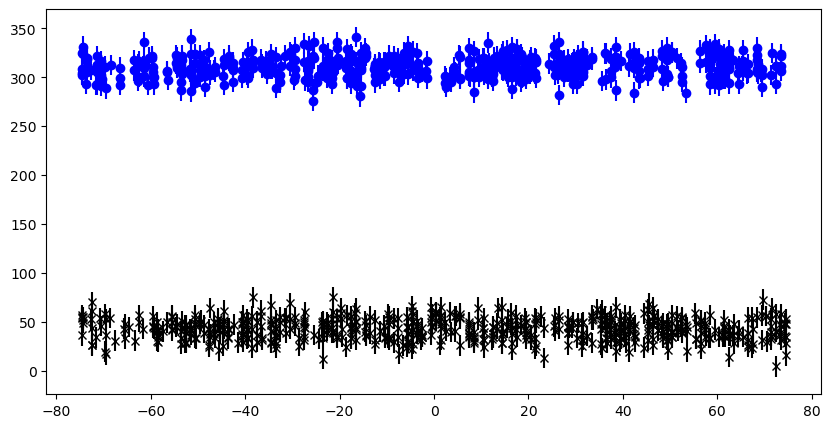

In [130]:
# Loop through the data using the new Spitzer_lc_detectable function.
#Spitzer_lc_detectable(ml, dl, ds, u0_earth, phi, phi_binary, d_binary, tE, FS1_I, FS2_I, FB_I, FS1_L, FS2_L, FB_L)
"""
Tags a cell Spitzer-only detectable if a source is only microlensed as seen
from Spitzer.

Inputs:
ml: mass of the lens in solar masses
ds: distance to the primary source in parsecs
dl: distance to the lens in parsecs
u0_earth: u0 of the event as seen from Earth in units of Einstein radius
phi: angle between Earth and Spitzer in degrees
phi_binary: angle of binary separation in degrees
d_binary: distance between the two sources in AU
tE: Einstein radius crossing time (days)
FS1_I: flux of the primary source seen from Earth
FS2_I: flux of the secondary source seen from Earth
FB_I: flux of the blend seen from Earth
FS1_L: flux of the primary source seen from Spitzer
FS2_L: flux of the secondary source seen from Spitzer
FB_L: flux of the blend seen from Spitzer

Returns whether or not the secondary source appears lensed from Spitzer only.
"""
mu_rel_mas_days = table['mu_rel_mas_yr']/365.25
table['tE'] = table['theta_E_mas']

# for the new table (no distance modulus needed)
def mag_to_flux(m):
    return 10**((25.0-m)/2.5)

# Initialize empty DataFrame for parameters
params_array = pd.DataFrame()
real_data_array_lc = []

for i in range(1): # Looping through the first row for testing
    print(type(table["D_L_kpc"][i]*1000))
    real_data_lc, params = Spitzer_lc_detectable(
        ml = table["M_L"][i],
        dl = table["D_L_kpc"][i]*1000,
        ds = table["D_S_kpc"][i]*1000,
        u0_earth = table["u0"][i],
        phis = np.linspace(0,359,2),
        phi_binary = table["binary_phi_deg"][i],
        d_binary = table["binary_sep_au"][i],
        tE = table['tE'][i],
        FS1_I = mag_to_flux(table["I_S"][i]),
        FS2_I = mag_to_flux(table["I_S2"][i]),
        FB_I = mag_to_flux(table["I_L"][i]),
        FS1_L = mag_to_flux(table["L_S"][i]),
        FS2_L = mag_to_flux(table["L_S2"][i]),
        FB_L = mag_to_flux(table["L_L"][i])
    )
    real_data_array_lc.append(real_data_lc)
    params_array = pd.concat([params_array, params], ignore_index=True)
    print(params_array.shape)

real_data_array_lc = np.array(real_data_array_lc)
print(real_data_array_lc)
params_array.to_csv('output.csv', index=False)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
params_array.head()

In [126]:
n_samples = 1
n_phis = 2

for i in range(n_samples):
   for j in range(n_phis):
      print(f"{i}: {real_data_array[i][j]}, {real_data_array_lc[i][j]}")
      # print chi2 values
      row = n_phis*i + j
      df_row = params_array.iloc[row]
      print(f"    delta chi2: {df_row['chi2_earth_flat'] - df_row['chi2_earth_binary']}")
      print(f"              : {df_row['chi2_spitzer_flat'] - df_row['chi2_spitzer_binary1']}")
      # print u0 values
      print(f"            u0: {df_row['u0_earth']}, {df_row['u0_earth_s2']}")
      print(f"              : {df_row['u0_spitzer_s1']}, {df_row['u0_spitzer_s2']}")

# Key:
# aceg (blue) = S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.
# adfh (red) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.
# adeh (green) = S1 detectable from Earth but not Spitzer, S2 not detectable.
# adfg (yellow) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.
# adeg (magenta) = S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.
# acfh (cyan) = S1 detectable from Earth and Spitzer, S2 detectable from Earth only.
# aceh (orange) = S1 detectable from Earth and Spitzer, S2 not detectable.
# acfg (purple) = S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer.

# These are irrelevant, right? I'm putting them in the dictionary anyway just in case.
# bdfh = S1 not detectable from earth or Spitzer, S2 detectable from earth only.
# bdeh = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bdfg = S1 not detectable from earth or Spitzer, S2 detectable from Earth and Spitzer.
# bdeg = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bcfh = S1 not detectable from earth but detectable from Spitzer, S2 detectable from earth only.
# bceh = S1 not detectable from earth but detectable from Spitzer, S2 not detectable.
# bceg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Spitzer only.
# bcfg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Earth and Spitzer.

IndexError: list index out of range

In [110]:
params = np.load("params_array.npy")
print(params.shape)

(3960, 30)


In [ ]:
ptest = params_array[1]
print(ptest)
print(f"Spitzer data: {spitzer_data}\n")
print(f"Earth data: {earth_data}\n")

In [ ]:
# Plotting histograms to show distribution of parameters.

u0s = table['u0']
plt.hist(u0s, bins=25)
plt.xlabel('$u_0 (θ_E)$')
plt.ylabel('Frequency')
plt.savefig("u0_hist.png")
plt.show()
print(np.median(u0s))
print(np.mean(u0s))

mls = table['M_L']
plt.hist(mls, bins=np.arange(0, 2.5, 0.1))
plt.xlim(0, 1.6)
plt.xlabel('M$_L$ $(M_{\\odot})$')
plt.ylabel('Frequency')
plt.savefig("ml_hist.png")
plt.show()

d_ratio = D_L/table['D_S_kpc']
plt.hist(d_ratio, bins=25)
plt.xlabel('D$_L$/D$_S$')
plt.ylabel('Frequency')
plt.savefig("d_hist.png")
plt.show()

binaryseparation = table['binary_sep_au']
plt.hist(binaryseparation, bins=25)#np.arange(0, 1, 0.05))
#plt.xlim(0, 50)
plt.yscale('log')
plt.xlabel('binary separation (AU)')
plt.ylabel('Frequency')
plt.savefig("dbinary_hist.png")
plt.show()
print(np.median(binaryseparation))

thetae = table['theta_E_mas']
plt.hist(thetae, bins=50)
plt.xlim(0, 1.5)
plt.xlabel('$θ_E$ (mas)')
plt.ylabel('Frequency')
plt.savefig("thetae_hist.png")
plt.show()

plt.scatter(binaryseparation, u0s, s=2)
plt.xlim(-0.1, 10.1)
plt.ylim(-1,1)
plt.xlabel('$d_{binary}$ (AU)')
plt.ylabel('$u_0 (θ_E)$')
plt.savefig("dbinary_u0_scatter.png")
plt.show()

phi_binaries = table["binary_phi_deg"]
plt.hist(phi_binaries, bins=50)
plt.xlabel('$\phi_{binary}$ (degrees)')
plt.ylabel('Frequency')
plt.savefig("phibinary_hist.png")
plt.show()

In [ ]:
u0_array = np.linspace(-2, 2, 401)  # Units of theta_E
phi_array = np.linspace(0, 180, 181) # degrees
dbinary_array = np.arange(0.1, 10.1, 0.1) #swap to logspace #In AU

#print(len(u0_array))
#print(len(dbinary_array))

n = -90 #phi_binary = 0/360 gives the most blues.

detection_grid = Spitzer_detectable(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)
#detection_grid = Spitzer_detectable_new(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)

#print the shape of detection grid

for i in range(1, len(u0_array)):
    for j in [90]: # 90˚ is max, 0/180˚ is min. So the range for relevant values of phi is 0-180˚.t
        sd = Spitzer_detectable(0.2, 7000, 8500, u0_array[i], j, n, dbinary_array)
        detection_grid = np.vstack((detection_grid, sd))
print(detection_grid.shape)
#for i in range(1, len(u0_array)):
    #for j in [90]: # 90˚ is max, 0/180˚ is min. So the range for relevant values of phi is 0-180˚.
        #sd = Spitzer_detectable_new(0.2, 7000, 8500, u0_array[i], j, n, dbinary_array)
        #detection_grid = np.vstack((detection_grid, sd))

X, Y = np.meshgrid(dbinary_array, u0_array) # To put d_binary in units of thetaE: (np.divide(dbinary_array,einstein_radius(0.2, 7000, 8500)))
print(X.shape, Y.shape)
print(X.size, Y.size)

colors = np.array(["black", "blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple", "white", "white", "white", "white",
                   "white", "white", "white"])

# Dictionary to assign each output to a number.
Spitzer_detectable_outputs = {"aceg":1, "adfh":2, "adeh":3, "adfg":4, "adeg":5, "acfh":6,
                              "aceh":7,"acfg":8,  "bdfh":9, "bdeh":10,
                              "bdfg":11, "bdeg":12, "bcfh":13, "bceh":14,
                              "bceg":15, "bcfg":16}

for i in range(len(detection_grid)):
    for j in range(len(detection_grid[0])):
        detection_grid[i,j] = Spitzer_detectable_outputs[detection_grid[i,j]]

numbers = detection_grid.astype(int)
subs_arr = colors[numbers]
#print(subs_arr.shape)
#print(subs_arr.size)

import matplotlib.patches as mpatches

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X.flatten(), Y.flatten(), color = subs_arr.flatten(), alpha = 0.5)
ax.scatter(binaryseparation, u0s, color = "black", s=5)
# ax.set_xlim(10e-2,10e1)
# ax.set_xscale("log")
ax.set_xlabel(r'$d_{binary}$ (AU)')
ax.set_ylabel(r'$u_{0,Earth}$')
ax.set_xlim(-0.1, 10.1)
ax.set_ylim(-1, 1)

blue_patch = mpatches.Patch(color='blue', label="S1 detectable from Spitzer, S2 detectable from Spitzer only.")
red_patch = mpatches.Patch(color='red', label="S1 not detectable from Spitzer, S2 detectable from Earth only.")
green_patch = mpatches.Patch(color='green', label="S1 not detectable from Spitzer, S2 not detectable.")
yellow_patch = mpatches.Patch(color='yellow', label="S1 not detectable from Spitzer, S2 detectable from Earth and Spitzer.")
magenta_patch = mpatches.Patch(color='magenta', label="S1 not detectable from Spitzer, S2 detectable from Spitzer only.")
cyan_patch = mpatches.Patch(color='cyan', label="S1 detectable from Spitzer, S2 detectable from Earth only.")
orange_patch = mpatches.Patch(color='orange', label="S1 detectable from Spitzer, S2 not detectable.")
purple_patch = mpatches.Patch(color='purple', label="S1 detectable from Spitzer, S2 detectable from Earth and Spitzer.")

ax.legend(handles=[blue_patch, red_patch, green_patch, yellow_patch, magenta_patch, cyan_patch,
                   orange_patch, purple_patch], bbox_to_anchor=(0.5, -0.1), loc="upper center")
plt.savefig("parameter_space_w_data.png", bbox_inches='tight')
plt.show()

In [ ]:
# Load data into spitzer_detectable_array function
parsec = 3.086e16 # So I don't have to go back and run the beginning cells
AU = 1.5e11
M_sol = 2e30

#real_data_array = np.zeros(len(table))
real_data_yay_array = Spitzer_detectable_array(u0_array=np.array([table["u0"][0]]),
                                             dbinary_array=np.array([table["binary_sep_au"][0]]), ml=np.array([table["M_L"][0]]),
                                             dl=np.array([table["D_L_kpc"][0]*1000]), ds=np.array([table["D_S_kpc"][0]*1000]))

for i in range(1,len(table)):
    real_data_yay = Spitzer_detectable_array(u0_array=np.array([table["u0"][i]]),
                                             dbinary_array=np.array([table["binary_sep_au"][i]]), ml=np.array([table["M_L"][i]]),
                                             dl=np.array([table["D_L_kpc"][i]*1000]), ds=np.array([table["D_S_kpc"][i]*1000]))
    #print(real_data_yay)
    real_data_yay_array = np.vstack((real_data_yay_array, real_data_yay))
#print(real_data_yay_array)
#print(len(real_data_array))
print(np.sum(real_data_yay_array))

#real_data_yay_array_new = np.array([])
#for i in range(len(table)):
    #real_data_new = Spitzer_detectable_array_new(u0_array=np.array([table["u0"][i]]),
                                                 #dbinary_array=np.array([table["binary_sep_au"][i]]), ml=np.array([table["M_L"][i]]),
                                                 #dl=np.array([table["D_L_kpc"][i]*1000]), ds=np.array([table["D_S_kpc"][i]*1000]))
    #print(real_data_yay)
    #real_data_yay_array_new = np.append(real_data_yay_array, real_data_new)
#print(real_data_array)
#print(sum(real_data_yay_array_new))

#real_data_array = np.array([])
#for i in range(len(table)):
    #real_data = Spitzer_detectable(ml=np.array([table["M_L"][i]]),
                                   #dl=np.array([table["D_L_kpc"][i]*1000]), ds=np.array([table["D_S_kpc"][i]*1000]),
                                   #u0_earth=np.array([table["u0"][i]]), phi=np.linspace(1,181), phi_binary = 0,
                                   #d_binary=np.array([table["binary_sep_au"][i]]))
    #print(real_data_yay)
    #real_data_array = np.append(real_data_array, real_data)
#print(sum(real_data_array))
#print(np.where(real_data_array == 1))

#np.save('real_data_array.npy', real_data_array)

#test = Spitzer_detectable(ml=np.array([table["M_L"][1]]), dl=np.array([table["D_L_kpc"][1]*1000]),
                          #ds=np.array([table["D_S_kpc"][1]*1000]), u0_earth=np.array([table["u0"][1]]),
                          #phi=np.linspace(1,181), phi_binary = 0, d_binary=np.array([table["binary_sep_au"][1]]))
#print(test)

#test2 = Spitzer_detectable_array(u0_array=np.array([table["u0"][11]]), dbinary_array=np.array([table["binary_sep_au"][11]]),
                                 #ml=np.array([table["M_L"][11]]), dl=np.array([table["D_L_kpc"][11]*1000]),
                                 #ds=np.array([table["D_S_kpc"][11]*1000]))
#print(test2)

In [ ]:
# Plotting the distribution of different numbers/colors for the real data (in the same manner as the simulation above).

#Initialize the array.
real_data_array = np.array(Spitzer_detectable(ml=np.array([table["M_L"][0]]),
                                   dl=np.array([table["D_L_kpc"][0]*1000]),
                                   ds=np.array([table["D_S_kpc"][0]*1000]),
                                   u0_earth=np.array([table["u0"][0]]),
                                   phi=np.linspace(0,360,360),
                                   phi_binary=np.array([table["binary_phi_deg"][0]]),
                                   d_binary=np.array([table["binary_sep_au"][0]])))

# Run the data.
for i in indices[1:]:
    real_data = Spitzer_detectable(ml=np.array([table["M_L"][i]]),
                                   dl=np.array([table["D_L_kpc"][i]*1000]),
                                   ds=np.array([table["D_S_kpc"][i]*1000]),
                                   u0_earth=np.array([table["u0"][i]]),
                                   phi=np.linspace(0,360,360),
                                   phi_binary=np.array(table["binary_phi_deg"][i]),
                                   d_binary=np.array([table["binary_sep_au"][i]]))
    real_data_array = np.vstack((real_data_array, real_data))

# Dictionary to assign each output to a number.
Spitzer_detectable_outputs = {"aceg":1, "adfh":2, "adeh":3, "adfg":4, "adeg":5,
                              "acfh":6, "aceh":7, "acfg":8, "bdfh":9, "bdeh":10,
                              "bdfg":11, "bdeg":12, "bcfh":13, "bceh":14,
                              "bceg":15, "bcfg":16}

for i in range(len(real_data_array)):
    for j in range(len(real_data_array[0])):
        real_data_array[i,j] = Spitzer_detectable_outputs[real_data_array[i,j]]

real_data_array = real_data_array.astype(int)
#Initialize the array.
"""
real_data_array = np.array(Spitzer_detectable_new(ml=np.array([table["M_L"][0]]),
                                   dl=np.array([table["D_L_kpc"][0]*1000]), ds=np.array([table["D_S_kpc"][0]*1000]),
                                   u0_spitzer=np.array([table["u0"][0]]), phi=np.linspace(0,360,360), phi_binary = -90,
                                   d_binary=np.array([table["binary_sep_au"][0]])))

# Run the data.
for i in range(1, len(table)):
    real_data = Spitzer_detectable_new(ml=np.array([table["M_L"][i]]),
                                   dl=np.array([table["D_L_kpc"][i]*1000]), ds=np.array([table["D_S_kpc"][i]*1000]),
                                   u0_spitzer=np.array([table["u0"][i]]), phi=np.linspace(0,360,360), phi_binary = -90,
                                   d_binary=np.array([table["binary_sep_au"][i]]))
    real_data_array = np.vstack((real_data_array, real_data))
    """


# Count the values for each color.
test_count1 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 1:
            test_count1 += 1

test_count2 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 2:
            test_count2 += 1

test_count3 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 3:
            test_count3 += 1

test_count4 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 4:
            test_count4 += 1

test_count5 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 5:
            test_count5 += 1

test_count6 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 6:
            test_count6 += 1

test_count7 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 7:
            test_count7 += 1

test_count8 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 8:
            test_count8 += 1

test_count9 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 9:
            test_count9 += 1

test_count10 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 10:
            test_count10 += 1

test_count11 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 11:
            test_count11 += 1

test_count12 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 12:
            test_count12 += 1

test_count13 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 13:
            test_count13 += 1

test_count14 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 14:
            test_count14 += 1

test_count15 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 15:
            test_count15 += 1

test_count16 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 16:
            test_count16 += 1

print(100*test_count1/(len(real_data_array)*360))

# Make the plot.
categories = ["blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple"]#, "darkblue", "darkred", "darkgreen", "gold",
                   #"darkmagenta", "darkcyan", "darkorange", "black"]
counts = [test_count1, test_count2, test_count3, test_count4, test_count5,
          test_count6, test_count7, test_count8]#, test_count9, test_count10,
          #test_count11, test_count12, test_count13, test_count14, test_count15,
          #test_count16]
colors = np.array(["blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple"])#, "darkblue", "darkred", "darkgreen", "gold",
                   #"darkmagenta", "darkcyan", "darkorange", "black"])
# for the legend
blue_patch = mpatches.Patch(color='blue', label="S1 detectable from Spitzer, S2 detectable from Spitzer only.")
red_patch = mpatches.Patch(color='red', label="S1 not detectable from Spitzer, S2 detectable from Earth only.")
green_patch = mpatches.Patch(color='green', label="S1 not detectable from Spitzer, S2 not detectable.")
yellow_patch = mpatches.Patch(color='yellow', label="S1 not detectable from Spitzer, S2 detectable from Earth and Spitzer.")
magenta_patch = mpatches.Patch(color='magenta', label="S1 not detectable from Spitzer, S2 detectable from Spitzer only.")
cyan_patch = mpatches.Patch(color='cyan', label="S1 detectable from Spitzer, S2 detectable from Earth only.")
orange_patch = mpatches.Patch(color='orange', label="S1 detectable from Spitzer, S2 not detectable.")
purple_patch = mpatches.Patch(color='purple', label="S1 detectable from Spitzer, S2 detectable from Earth and Spitzer.")

# labeldict = {"blue":"S2 detectable from Spitzer only.",
             # "red":"S2 detectable from Earth only.",
             # "green":"S2 not detectable.",
             # "yellow":"S2 detectable from Earth and Spitzer.",
             # "magenta":"S2 detectable from Spitzer only.",
             # "cyan":"S2 detectable from Earth only.",
             # "orange":"S2 not detectable.",
             # "purple":"S2 detectable from Earth and Spitzer."}

# Plot the graph.
plt.bar(categories, counts, color=colors)#, label=labeldict[categories])
plt.xlabel('Scenarios')
plt.ylabel('Frequency')
plt.legend(handles=[blue_patch, red_patch, green_patch, yellow_patch, magenta_patch, cyan_patch,
                   orange_patch, purple_patch], bbox_to_anchor=(0.5, -0.15), loc="upper center")
# Adjust the plot's right margin to make space for the legend
#plt.subplots_adjust(right=0.7)

plt.savefig("bargraph.png", bbox_inches='tight')
plt.show()


print((test_count1/(test_count1 + test_count8 + test_count7)*100)*0.4051) # cut
print(real_data_array.shape)

#print(len(real_data_array))
#print(real_data_array.shape)

In [ ]:
# Make a scatterplot.

phi_test = np.ones(360)
#delta_db = np.logspace(-1, 0, 360)
u0_array_big = table["u0"][0]*phi_test
#d_binary_big = table["binary_sep_au"][0]*phi_test + np.logspace(table["binary_sep_au"][0]*0.1, table["binary_sep_au"][0]*10, 360)
d_binary_big = np.logspace(np.log10(table["binary_sep_au"][0])-0.01, np.log10(table["binary_sep_au"][0])+0.01, 360)
for i in indices[1:]:
    u0_array_big = np.vstack((u0_array_big, table["u0"][i]*phi_test))
    #d_binary_big = np.vstack((d_binary_big, table["binary_sep_au"][i]*phi_test + np.logspace(table["binary_sep_au"][i]*0.1, table["binary_sep_au"][i]*10, 360)))
    d_binary_big = np.vstack((d_binary_big, np.logspace(np.log10(table["binary_sep_au"][i])-0.01, np.log10(table["binary_sep_au"][i])+0.01, 360)))


numbers = real_data_array.astype(int)
colors = np.array(["black", "blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple", "white", "white", "white", "white", "white",
                   "white", "white", "white"])
subs_arr = colors[numbers]
bluesplot = np.where(numbers.flatten() == 1)[0]

fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(d_binary_big.flatten(), u0_array_big.flatten(), color = subs_arr.flatten(), alpha = 0.5, s=2)
ax.scatter(d_binary_big.flatten()[bluesplot], u0_array_big.flatten()[bluesplot],
           color = subs_arr.flatten()[bluesplot], s=5) # Plot just the blues on top.

# For the legend:
blue_patch = mpatches.Patch(color='blue', label="S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.")
red_patch = mpatches.Patch(color='red', label="S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.")
green_patch = mpatches.Patch(color='green', label="S1 detectable from Earth but not Spitzer, S2 not detectable.")
yellow_patch = mpatches.Patch(color='yellow', label="S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.")
magenta_patch = mpatches.Patch(color='magenta', label="S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.")
cyan_patch = mpatches.Patch(color='cyan', label="S1 detectable from Earth and Spitzer, S2 detectable from Earth only.")
orange_patch = mpatches.Patch(color='orange', label="S1 detectable from Earth and Spitzer, S2 not detectable.")
purple_patch = mpatches.Patch(color='purple', label="S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer.")

ax.set_title(r'Scatterplot of Spitzer-detectable secondary sources: $d_{binary}$ vs. $u_{0,Earth}$')
ax.set_xlabel(r'$d_{binary}$')
ax.set_ylabel(r'$u_{0,Earth}$')
ax.set_xlim(10e-2,10e1)
ax.set_xscale("log")
ax.set_ylim(-1.1,1.1)
plt.legend(handles=[blue_patch, red_patch, green_patch, yellow_patch, magenta_patch, cyan_patch,
                   orange_patch, purple_patch], bbox_to_anchor=(0.5, -0.15), loc="upper center")
plt.show()